## ReMECS -- Real-time Multimodal Emotion Classification Syatem

## Using multimodal data stream [EEG+EDA+RESP_BELT] 
## Using MLP + SGD + One pass + Weighted Majority Voting

## Modifications:
- New Feature Set for EDA and Resp Belt. 
- Feature normalization is done.
- RECS with other modalities (EDA + Resp Belt) is incorporated for Real-time Multimodal Emotion Classification System (ReMECS).
- Weighted Majority Vote is used for Decision Fusion. 


## Date: 19 MARCH 2021 at 10:10 AM

In [1]:
#============================
# Import important libraries
#============================
import pandas as pd 
import numpy as np
import math
import scipy
import pywt
from creme import metrics
import time
import datetime
from statistics import mode
from scipy import stats
from sklearn import preprocessing
from collections import defaultdict, Counter
from scipy.special import expit
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

from ANNClassifier import * 
from window_slider import Slider

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)> 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):    
    list_values = list_values[0,:]
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [3]:
#======================================================
# EDA Feature Extraction (Wavelet Features)
#======================================================
def extract_eda_features(raw_eda):
    features =[]
    EDA = raw_eda
    list_coeff = pywt.wavedec(EDA, 'db4', level=3)
    
#     print(list_coeff)
    for coeff in list_coeff:
        features += get_features(coeff)
    return features


In [4]:
#======================================================
# RESP BELT Feature Extraction (Wavelet Features)
#======================================================

def extract_resp_belt_features(raw_data):
    features =[]
    resp_belt = raw_data
    list_coeff = pywt.wavedec(resp_belt, 'db4', level=3)
    
#     print(list_coeff)
    for coeff in list_coeff:
        features += get_features(coeff)
    return features

In [5]:
def eeg_features(raw_data):
    ch = 0
    features= []
    def calculate_entropy(list_values):
        counter_values = Counter(list_values).most_common()
        probabilities = [elem[1]/len(list_values) for elem in counter_values]
        entropy=scipy.stats.entropy(probabilities)
        return entropy

    def calculate_statistics(list_values):
        median = np.nanpercentile(list_values, 50)
        mean = np.nanmean(list_values)
        std = np.nanstd(list_values)
        var = np.nanvar(list_values)
        rms = np.nanmean(np.sqrt(list_values**2))
        return [median, mean, std, var, rms]

    def get_features(list_values):    
    #     list_values = list_values[0,:]
        entropy = calculate_entropy(list_values)
        statistics = calculate_statistics(list_values)
        return [entropy] + statistics
    
    for i in range(raw_data.shape[0]):
        ch_data = raw_data[i]
        list_coeff = pywt.wavedec(ch_data, 'db4', level=5)
        for coeff in list_coeff:
            features += get_features(coeff)
            
        ch = ch+1
    return features

In [6]:
##===================================================
# EEG data read from files
##===================================================
def eeg_data(p,v):
    file_eeg = '/home/gp/Desktop/MER_arin/data/eeg_data/'+str(p)+'_data_DEAP'+'.csv'
    print(file_eeg)
    df = pd.read_csv(file_eeg,sep=',', header = None, engine='python')
    eeg_sig = df.loc[df.iloc[:,1] == v]
    return eeg_sig

##===================================================
# EDA data read from files
##===================================================
def eda_data(p,v):
    file_eda = '/home/gp/Desktop/MER_arin/data/eda_data/'+str(p)+'_GSR_data_from_DEAP.csv'
    print(file_eda)
    df = pd.read_csv(file_eda,sep=',', header = None, engine='python')
    eda_sig = df.loc[df.iloc[:,1] == v]
    return eda_sig

##===================================================
# Resp data read from files
##===================================================
def resp_data(p,v):
    file_resp = '/home/gp/Desktop/MER_arin/data/resp_data/'+str(p)+'_Respiration_data_from_DEAP.csv'
    print(file_resp)
    df = pd.read_csv(file_resp,sep=',', header = None, engine='python')
    resp_sig = df.loc[df.iloc[:,1] == v]
    return resp_sig

In [8]:
#=======================================
# MAIN PROGRAM STARTS HERE
#=======================================

segment_in_sec = 10 #in sec
bucket_size = int((8064/60)*segment_in_sec)  #8064 is for 60 sec record
overlap_count = 0

num_classifiers = 3 #Total number of classifiers
w_val =np.ones(num_classifiers)/num_classifiers #Weights for valence classifiers
w_aro =np.ones(num_classifiers)/num_classifiers #Weights for valence classifiers
beta = 0.5

# l_max =0.9999
# lr_min = 0.0001
eta = 0.05
b =1 


n_epoch =1
epochs =  1 #epoch is 1 because the model will be trained only once
# optimizer= 'sgd' #optimizer

optimizer= 'SGD' #optimizer
classifier = 'MLP_'+str(optimizer)
c = 0
run = 1

participant = 32
videos = 40

global eeg_emotion, eda_emotion, resp_emotion, mer_emotion, all_eta
eeg_emotion = []
eda_emotion = []
resp_emotion = []
mer_emotion = []

all_eta =[]
init_m = 0

#================================================
# Performance matric declaration here
#================================================
mer_acc_val = metrics.Accuracy() #Accuracy
mer_f1m_val = metrics.F1() #F1 measure  
mer_acc_aro = metrics.Accuracy() #Accuracy
mer_f1m_aro = metrics.F1() #F1 measure
mer_roc_val = metrics.ROCAUC()
mer_roc_aro = metrics.ROCAUC() 
mer_mcc_val = metrics.MCC()
mer_mcc_aro = metrics.MCC()


eeg_acc_val = metrics.Accuracy() #Accuracy
eeg_f1m_val = metrics.F1() #F1 measure  
eeg_acc_aro = metrics.Accuracy() #Accuracy
eeg_f1m_aro = metrics.F1() #F1 measure
eeg_roc_val = metrics.ROCAUC()
eeg_roc_aro = metrics.ROCAUC()
eeg_mcc_val = metrics.MCC()
eeg_mcc_aro = metrics.MCC()

eda_acc_val = metrics.Accuracy() #Accuracy
eda_f1m_val = metrics.F1() #F1 measure  
eda_acc_aro = metrics.Accuracy() #Accuracy
eda_f1m_aro = metrics.F1() #F1 measure
eda_roc_val = metrics.ROCAUC()
eda_roc_aro = metrics.ROCAUC()
eda_mcc_val = metrics.MCC()
eda_mcc_aro = metrics.MCC()

resp_acc_val = metrics.Accuracy() #Accuracy
resp_f1m_val = metrics.F1() #F1 measure  
resp_acc_aro = metrics.Accuracy() #Accuracy
resp_f1m_aro = metrics.F1() #F1 measure
resp_roc_val = metrics.ROCAUC()
resp_roc_aro = metrics.ROCAUC()
resp_mcc_val = metrics.MCC()
resp_mcc_aro = metrics.MCC()

 
mer_cm_val  = metrics.ConfusionMatrix()
mer_cm_aro  = metrics.ConfusionMatrix()

eeg_cm_val  = metrics.ConfusionMatrix()
eeg_cm_aro  = metrics.ConfusionMatrix()

eda_cm_val  = metrics.ConfusionMatrix()
eda_cm_aro  = metrics.ConfusionMatrix()
  
resp_cm_val  = metrics.ConfusionMatrix()
resp_cm_aro  = metrics.ConfusionMatrix()
    
itr = 0 #controls the learning rate


for ii in range(0,participant):


        # if(ii >2):
        # 	break

        p =ii+1
        for jj in range(0,videos):
            v = jj+1
            p_v = 'Person:'+ ' ' +str(p)+ ' ' +'Video:'+str(v)
            
            emotion_label =[]
            
            print('------------------------------------------------')
            ##===================================================
            # Data read from files
            ##===================================================
            eeg_sig = eeg_data(p,v)
            eda_sig = eda_data(p,v)
            resp_sig = resp_data(p,v)
            
            #=================================================
            #emotion labels (valence, arousal) mapping 0-1
            #=================================================
            val = eeg_sig.iloc[0,8067]
            aro = eeg_sig.iloc[0,8068]
            
            #valence emotion maping 0-> low valence and 1-> high valence

            if (val >5):
                vl = 1 #high valence
            else:
                vl = 0 #low valence

            #arousal emotion maping 0-> low arousal and 1-> high high arousal
            if (aro >5):
                al = 1 #high arousal
            else:
                al = 0 #low arousal
                
            y_act_val = vl
            y_act_aro = al 
            
            
            #=========================================
            # Sliding window starts here 
            #=========================================
            slider_eeg = Slider(bucket_size,overlap_count)
            slider_eda = Slider(bucket_size,overlap_count)
            slider_resp = Slider(bucket_size,overlap_count)
            
            eeg_sig = np.array(eeg_sig.iloc[range(0,32),range(3,8067)]) #keeping only eeg signals
            eda_sig = np.array(eda_sig.iloc[:,range(3,8067)]) #keeping only eda signals
            resp_sig = np.array(resp_sig.iloc[:,range(3,8067)]) #keeping only resp signals
            
            slider_eeg.fit(eeg_sig)
            slider_eda.fit(eda_sig)
            slider_resp.fit(resp_sig)

            while True:
                window_data_eeg = slider_eeg.slide()
                window_data_eda = slider_eda.slide() 
                window_data_resp = slider_resp.slide() 
                
                #=================================================
                # Feature extraction from EEG
                #=================================================
                features_eeg = eeg_features(window_data_eeg)
                eeg = np.array([features_eeg])  #EEG raw feature vector
                x_eeg = preprocessing.normalize(eeg) # EEG normalized features [0,1] 
                
                
                #=================================================
                # Feature extraction from EDA
                #=================================================
                eda_features = extract_eda_features(np.array(window_data_eda))
                eda = np.array([eda_features]) #EDA raw feature vector
                x_eda = preprocessing.normalize(eda) #EDA normalized features
                
                #=================================================
                # Feature extraction from Resp belt
                #=================================================

                resp_features = extract_resp_belt_features(np.array(window_data_resp))
                resp = np.array([resp_features]) #RESP BELT raw feature vector
                x_resp = preprocessing.normalize(resp) #RESP BELT normalized features
            
            
                #===================================================
                # Model initialization
                #===================================================
                if init_m == 0:
                    print('EEG Feature shape{}:'.format(x_eeg.shape))
                    print('EDA Feature shape{}:'.format(x_eda.shape))
                    print('RESP BELT Feature shape{}:'.format(x_resp.shape))

                    eeg_size_hidden = 30 #math.ceil((2/3)*x_eeg.shape[1]) #Hidden node size
                    eda_size_hidden = math.ceil((2/3)*x_eda.shape[1]) #Hidden node size
                    resp_size_hidden = math.ceil((2/3)*x_resp.shape[1]) #Hidden node size

                    print('EEGNet Hidden Node: {}'.format(eeg_size_hidden))
                    print('EDANet Hidden Node: {}'.format(eda_size_hidden))
                    print('RESPBELTNet Hidden Node: {}'.format(resp_size_hidden))

                    #========================
                    # For EEG data MLP model
                    #========================
                    eeg_model_val = ANN()
                    eeg_model_val.add(layers.layer(x_eeg.shape[1], 'sigmoid'))
                    eeg_model_val.add(layers.layer(eeg_size_hidden, 'sigmoid'))
                    eeg_model_val.add(layers.layer(1, 'sigmoid'))


                    eeg_model_aro = ANN()
                    eeg_model_aro.add(layers.layer(x_eeg.shape[1], 'sigmoid'))
                    eeg_model_aro.add(layers.layer(eeg_size_hidden, 'sigmoid'))
                    eeg_model_aro.add(layers.layer(1, 'sigmoid'))

                    #========================
                    # For EDA data MLp model
                    #========================
                    eda_model_val = ANN()
                    eda_model_val.add(layers.layer(x_eda.shape[1], 'sigmoid'))
                    eda_model_val.add(layers.layer(eda_size_hidden, 'sigmoid'))
                    eda_model_val.add(layers.layer(1, 'sigmoid'))

                    eda_model_aro = ANN()
                    eda_model_aro.add(layers.layer(x_eda.shape[1], 'sigmoid'))
                    eda_model_aro.add(layers.layer(eda_size_hidden, 'sigmoid'))
                    eda_model_aro.add(layers.layer(1, 'sigmoid'))

                    #==============================
                    # For Resp Belt data MLP Model
                    #==============================
                    resp_model_val = ANN()
                    resp_model_val.add(layers.layer(x_resp.shape[1], 'sigmoid'))
                    resp_model_val.add(layers.layer(resp_size_hidden, 'sigmoid'))
                    resp_model_val.add(layers.layer(1, 'sigmoid'))

                    resp_model_aro = ANN()
                    resp_model_aro.add(layers.layer(x_resp.shape[1], 'sigmoid'))
                    resp_model_aro.add(layers.layer(resp_size_hidden, 'sigmoid'))
                    resp_model_aro.add(layers.layer(1, 'sigmoid'))


                    init_m = init_m+1


                #===============================================================
                # Emotion Classification --> Valence and Arousal
                #===============================================================

                #===========================================
                # From EEG data -- RECS System
                #===========================================

                #Valence classification EEG

                #Test the model first 
                y_pred_val_eeg = eeg_model_val.predict_once(x_eeg,c)

                #Train the model once
                eeg_model_val.fit_once(x_eeg,y_act_val, eta,c)

                eeg_acc_val = eeg_acc_val.update(y_act_val, y_pred_val_eeg[0])  # update the accuracy metric

                eeg_f1m_val = eeg_f1m_val.update(y_act_val, y_pred_val_eeg[0]) #update f1 measure metric
                
                eeg_roc_val = eeg_roc_val.update(y_act_val, y_pred_val_eeg[0])
                
                eeg_mcc_val = eeg_mcc_val.update(y_act_val, y_pred_val_eeg[0])

                #Arousal classification EEG

                #Test the model first 
                y_pred_aro_eeg = eeg_model_aro.predict_once(x_eeg,c)

                #Train the model once
                eeg_model_aro.fit_once(x_eeg,y_act_aro, eta,c)

                eeg_acc_aro = eeg_acc_aro.update(y_act_aro, y_pred_aro_eeg[0])  # update the accuracy metric

                eeg_f1m_aro = eeg_f1m_aro.update(y_act_aro, y_pred_aro_eeg[0]) #update f1 measure metric
                
                eeg_roc_aro = eeg_roc_aro.update(y_act_aro, y_pred_aro_eeg[0])
                
                eeg_mcc_aro = eeg_mcc_aro.update(y_act_aro, y_pred_aro_eeg[0])

                #===========================================
                # From EDA data 
                #===========================================

                #Valence classification EDA

                #Test the model first 
                y_pred_val_eda = eda_model_val.predict_once(x_eda,c)

                #Train the model once
                eda_model_val.fit_once(x_eda,y_act_val, eta,c)

                eda_acc_val = eda_acc_val.update(y_act_val, y_pred_val_eda[0])  # update the accuracy metric

                eda_f1m_val = eda_f1m_val.update(y_act_val, y_pred_val_eda[0]) #update f1 measure metric
                
                eda_roc_val = eda_roc_val.update(y_act_val, y_pred_val_eda[0])
                
                eda_mcc_val = eda_mcc_val.update(y_act_val, y_pred_val_eda[0])
                

                #Arousal classification EDA
                #Test the model first 
                y_pred_aro_eda = eda_model_aro.predict_once(x_eda,c)

                #Train the model once
                eda_model_aro.fit_once(x_eda,y_act_aro, eta,c)

                eda_acc_aro = eda_acc_aro.update(y_act_aro, y_pred_aro_eda[0])  # update the accuracy metric

                eda_f1m_aro = eda_f1m_aro.update(y_act_aro, y_pred_aro_eda[0]) #update f1 measure metric
                
                eda_roc_aro = eda_roc_aro.update(y_act_aro, y_pred_aro_eda[0])
                
                eda_mcc_aro = eda_mcc_aro.update(y_act_aro, y_pred_aro_eda[0])

                #===========================================
                # From Resp Belt data
                #===========================================

                #Valence classification Resp Belt

                #Test the model first 
                y_pred_val_resp = resp_model_val.predict_once(x_resp,c)

                #Train the model once
                resp_model_val.fit_once(x_resp,y_act_val, eta,c)

                resp_acc_val = resp_acc_val.update(y_act_val, y_pred_val_resp[0])  # update the accuracy metric

                resp_f1m_val = resp_f1m_val.update(y_act_val, y_pred_val_resp[0]) #update f1 measure metric
                
                resp_roc_val = resp_roc_val.update(y_act_val, y_pred_val_resp[0])
                
                resp_mcc_val = resp_roc_val.update(y_act_val, y_pred_val_resp[0])
                

                #Arousal classification Resp Belt
                #Test the model first 
                y_pred_aro_resp = resp_model_aro.predict_once(x_resp,c)

                #Train the model once
                resp_model_aro.fit_once(x_resp,y_act_aro, eta,c)

                resp_acc_aro = resp_acc_aro.update(y_act_aro, y_pred_aro_resp[0])  # update the accuracy metric

                resp_f1m_aro = resp_f1m_aro.update(y_act_aro, y_pred_aro_resp[0]) #update f1 measure metric
                
                resp_roc_aro = resp_roc_aro.update(y_act_aro, y_pred_aro_resp[0])
                
                resp_mcc_aro = resp_mcc_aro.update(y_act_aro, y_pred_aro_resp[0])
                
                
                c = c+1

                if slider_eeg.reached_end_of_list(): break
                
            
            ##=============================
            # Confusion Matric Calculation
            ##=============================
            
            eeg_cm_val = eeg_cm_val.update(y_act_val, y_pred_val_eeg[0])
            eeg_cm_aro = eeg_cm_aro.update(y_act_aro, y_pred_aro_eeg[0])
            
            eda_cm_val = eda_cm_val.update(y_act_val, y_pred_val_eda[0])
            eda_cm_aro = eda_cm_aro.update(y_act_aro, y_pred_aro_eda[0])
            
            resp_cm_val = resp_cm_val.update(y_act_val, y_pred_val_resp[0])
            resp_cm_varo = resp_cm_aro.update(y_act_aro, y_pred_aro_resp[0])            
            
            #=============================================================
            # Storing All Results
            #=============================================================
            
            emotion_label.append([y_pred_val_eeg,y_pred_aro_eeg]) #appending valence & arousal predicted EEG
            emotion_label.append([y_pred_val_eda, y_pred_aro_eda]) #appending valence & arousal predicted EDA
            emotion_label.append([y_pred_val_resp, y_pred_aro_resp]) #appending valence & arousal predicted resp

            emotion_label = np.array(emotion_label)
            
                    
            #==============================================================
            # Decision label ensemble --> Weighted Majority Voting
            #==============================================================
            val_label = emotion_label[:,0]
            aro_label = emotion_label[:,1]
            
            #------------------------------------------
            # Valence Class ensemble
            #------------------------------------------
            
            p_val = np.dot([w_val],val_label)
            y_prdt_mer_val = (p_val -0.5)
            if(y_prdt_mer_val > 0):
                mer_val = 1
            else:
                mer_val = 0

            for i in range(val_label.shape[0]):
                if(val_label[i] != y_act_val):
                    w_val[i] = beta*w_val[i]
            
            w_val_sum = sum(w_val) #total sum of weights
            
            w_val = np.array(w_val/w_val_sum) #weight rescaling
            
            #------------------------------------------
            # Arousal Class ensemble
            #------------------------------------------            
            p_val = np.dot([w_aro],aro_label)
            y_prdt_mer_aro = (p_val-0.5)
            if(y_prdt_mer_aro > 0):
                mer_aro = 1
            else:
                mer_aro = 0

            for i in range(aro_label.shape[0]):
                if(aro_label[i] != y_act_aro):
                    w_aro[i] = beta*w_aro[i]
            
            
            w_aro_sum = sum(w_aro) #total sum of weights
            
            w_aro = np.array(w_aro/w_aro_sum) #weight rescaling
            
            #========================================================
            # ReMECS performance metric 
            #========================================================
            mer_acc_val = mer_acc_val.update(y_act_val, mer_val)
            mer_f1m_val = mer_f1m_val.update(y_act_val, mer_val)
            mer_roc_val = mer_roc_val.update(y_act_val, mer_val)
            mer_mcc_val = mer_mcc_val.update(y_act_val, mer_val)
            
            mer_acc_aro = mer_acc_aro.update(y_act_aro, mer_aro)
            mer_f1m_aro = mer_f1m_aro.update(y_act_aro, mer_aro)
            mer_roc_aro = mer_roc_aro.update(y_act_aro, mer_aro)
            mer_mcc_aro = mer_mcc_aro.update(y_act_aro, mer_aro)
            
            eeg_emotion.append(np.array([p,v,eeg_acc_val.get(), eeg_f1m_val.get(), eeg_roc_val.get(),eeg_mcc_val.get(),
                                         eeg_acc_aro.get(), eeg_f1m_aro.get(),eeg_roc_aro.get(), eeg_mcc_aro.get(), 
                                         y_act_val, y_pred_val_eeg, y_act_aro, y_pred_aro_eeg]))
            
            eda_emotion.append(np.array([p,v,eda_acc_val.get(), eda_f1m_val.get(), eda_roc_val.get(),eda_mcc_val.get(),
                                         eda_acc_aro.get(), eda_f1m_aro.get(), eda_roc_aro.get(), eda_mcc_aro.get(),
                                         y_act_val, y_pred_val_eda, y_act_aro, y_pred_aro_eda]))
            
            resp_emotion.append(np.array([p,v, resp_acc_val.get(), resp_f1m_val.get(), resp_roc_val.get(), resp_mcc_val.get(),
                                          resp_acc_aro.get(),resp_f1m_aro.get(), resp_roc_aro.get(), resp_mcc_aro.get(), 
                                          y_act_val, y_pred_val_resp, y_act_aro, y_pred_aro_resp]))
            
            mer_emotion.append(np.array([p,v,mer_acc_val.get(), mer_f1m_val.get(), mer_roc_val.get(), mer_mcc_val.get(),
                                         mer_acc_aro.get(), mer_f1m_aro.get(), mer_roc_aro.get(), mer_mcc_aro.get(), 
                                         y_act_val, mer_val, y_act_aro, mer_aro]))
            print('===============================================================')
            print(p_v)
            print('Actual emotion [valence: {}, arousal: {}]'.format(y_act_val, y_act_aro))
            print('Single modal Predicted emotion')
            print('[valence, arousal]:')
            print(emotion_label)
            
            print('MER Predicted emotion [valence: {}, arousal: {}]'.format(mer_val, mer_aro))            
            print('..................................................')
            print('EEG')

            print("Valence Accuracy:{}".format(round(eeg_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(eeg_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(eeg_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(eeg_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(eeg_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(eeg_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(eeg_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(eeg_mcc_aro.get(),4)))

            print('..................................................')
            print('EDA')

            print("Valence Accuracy:{}".format(round(eda_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(eda_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(eda_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(eda_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(eda_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(eda_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(eda_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(eda_mcc_aro.get(),4)))


            print('..................................................')
            print('RESP BELT')

            print("Valence Accuracy:{}".format(round(resp_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(resp_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(resp_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(resp_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(resp_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(resp_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(resp_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(resp_mcc_aro.get(),4)))

            print('..................................................')
            print('MER model')

            print("Valence Accuracy:{}".format(round(mer_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(mer_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(mer_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(mer_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(mer_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(mer_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(mer_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(mer_mcc_aro.get(),4)))
                
                
                
            



------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
EEG Feature shape(1, 1152):
EDA Feature shape(1, 48):
RESP BELT Feature shape(1, 48):
EEGNet Hidden Node: 30
EDANet Hidden Node: 32
RESPBELTNet Hidden Node: 32
Person: 1 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.6667
Valence F1 score:0.8
Valence ROC score:-0.0
Valence MCC score:0.0
Arousal Accuracy:0.5
Arousal F1 score:0.6667
Arousal ROC score:-0.0
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.0
Valence F1 score:0.0
Valence ROC score:-0.0
Valence MCC score:0.0
Arousal Accurac

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:7
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8095
Valence F1 score:0.8889
Valence ROC score:0.6111
Valence MCC score:0.2222
Arousal Accuracy:0.619
Arousal F1 score:0.68
Arousal ROC score:0.6042
Arousal MCC score:0.2123
..................................................
EDA
Valence Accuracy:0.5714
Valence F1 score:0.7188
Valence ROC score:0.4028
Valence MCC score:-0.1443
Arousal Accuracy:0.4762
Arousal F1 score:0.3889
Arousal ROC score:0.5069
Arousal MCC score:0.0152
..................................................
RESP BELT
Valence Accuracy:0.4762
Valence F1 score:0.5926
Valence ROC score:0.5556
Valence MCC score:0.555

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8077
Valence F1 score:0.8352
Valence ROC score:0.7996
Valence MCC score:0.6181
Arousal Accuracy:0.7692
Arousal F1 score:0.6538
Arousal ROC score:0.7523
Arousal MCC score:0.4855
..................................................
EDA
Valence Accuracy:0.6795
Valence F1 score:0.6988
Valence ROC score:0.6786
Valence MCC score:0.3566
Arousal Accuracy:0.7179
Arousal F1 score:0.3889
Arousal ROC score:0.5995
Arousal MCC score:0.2547
..................................................
RESP BELT
Valence Accuracy:0.6154
Valence F1 score:0.5946
Valence ROC score:0.623
Valence MCC score:0.6

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7544
Valence F1 score:0.7705
Valence ROC score:0.7528
Valence MCC score:0.5068
Arousal Accuracy:0.7719
Arousal F1 score:0.75
Arousal ROC score:0.7694
Arousal MCC score:0.5422
..................................................
EDA
Valence Accuracy:0.6842
Valence F1 score:0.6667
Valence ROC score:0.6889
Valence MCC score:0.382
Arousal Accuracy:0.7368
Arousal F1 score:0.6591
Arousal ROC score:0.7269
Arousal MCC score:0.4952
..................................................
RESP BELT
Valence Accuracy:0.6491
Valence F1 score:0.6
Valence ROC score:0.6574
Valence MCC score:0.6574
A

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:25
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.8
Valence F1 score:0.8438
Valence ROC score:0.783
Valence MCC score:0.566
Arousal Accuracy:0.7533
Arousal F1 score:0.7613
Arousal ROC score:0.7532
Arousal MCC score:0.5062
..................................................
EDA
Valence Accuracy:0.76
Valence F1 score:0.8
Valence ROC score:0.7639
Valence MCC score:0.5104
Arousal Accuracy:0.7133
Arousal F1 score:0.6993
Arousal ROC score:0.7163
Arousal MCC score:0.4362
..................................................
RESP BELT
Valence Accuracy:0.7333
Valence F1 score:0.7674
Valence ROC score:0.7512
Valence MCC score:0.7512
Arous

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7849
Valence F1 score:0.823
Valence ROC score:0.7703
Valence MCC score:0.5539
Arousal Accuracy:0.7581
Arousal F1 score:0.7644
Arousal ROC score:0.758
Arousal MCC score:0.5158
..................................................
EDA
Valence Accuracy:0.7634
Valence F1 score:0.7925
Valence ROC score:0.7607
Valence MCC score:0.5182
Arousal Accuracy:0.6989
Arousal F1 score:0.6923
Arousal ROC score:0.7003
Arousal MCC score:0.4016
..................................................
RESP BELT
Valence Accuracy:0.7366
Valence F1 score:0.761
Valence ROC score:0.7393
Valence MCC score:0.739

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.8108
Valence F1 score:0.8158
Valence ROC score:0.8121
Valence MCC score:0.6261
Arousal Accuracy:0.7568
Arousal F1 score:0.784
Arousal ROC score:0.7535
Arousal MCC score:0.5058
..................................................
EDA
Valence Accuracy:0.8018
Valence F1 score:0.7925
Valence ROC score:0.8012
Valence MCC score:0.6033
Arousal Accuracy:0.7207
Arousal F1 score:0.748
Arousal ROC score:0.7192
Arousal MCC score:0.4359
..................................................
RESP BELT
Valence Accuracy:0.7793
Valence F1 score:0.761
Valence ROC score:0.7778
Valence MCC score:0.777

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.814
Valence F1 score:0.8222
Valence ROC score:0.8133
Valence MCC score:0.628
Arousal Accuracy:0.7907
Arousal F1 score:0.8323
Arousal ROC score:0.7782
Arousal MCC score:0.5541
..................................................
EDA
Valence Accuracy:0.7946
Valence F1 score:0.7888
Valence ROC score:0.7956
Valence MCC score:0.5929
Arousal Accuracy:0.7597
Arousal F1 score:0.805
Arousal ROC score:0.7492
Arousal MCC score:0.4928
..................................................
RESP BELT
Valence Accuracy:0.7791
Valence F1 score:0.7673
Valence ROC score:0.7807
Valence MCC score:0.7807

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.8061
Valence F1 score:0.8213
Valence ROC score:0.8039
Valence MCC score:0.6103
Arousal Accuracy:0.7687
Arousal F1 score:0.8057
Arousal ROC score:0.7593
Arousal MCC score:0.5201
..................................................
EDA
Valence Accuracy:0.7823
Valence F1 score:0.7881
Valence ROC score:0.7836
Valence MCC score:0.5661
Arousal Accuracy:0.7245
Arousal F1 score:0.7679
Arousal ROC score:0.7142
Arousal MCC score:0.429
..................................................
RESP BELT
Valence Accuracy:0.7687
Valence F1 score:0.7718
Valence ROC score:0.7708
Valence MCC score:0.77

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.803
Valence F1 score:0.8294
Valence ROC score:0.7963
Valence MCC score:0.5977
Arousal Accuracy:0.7394
Arousal F1 score:0.7795
Arousal ROC score:0.7292
Arousal MCC score:0.4615
..................................................
EDA
Valence Accuracy:0.7848
Valence F1 score:0.8055
Valence ROC score:0.7841
Valence MCC score:0.5655
Arousal Accuracy:0.7182
Arousal F1 score:0.7559
Arousal ROC score:0.712
Arousal MCC score:0.4227
..................................................
RESP BELT
Valence Accuracy:0.7758
Valence F1 score:0.7956
Valence ROC score:0.776
Valence MCC score:0.776

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8087
Valence F1 score:0.843
Valence ROC score:0.7952
Valence MCC score:0.6008
Arousal Accuracy:0.7295
Arousal F1 score:0.7775
Arousal ROC score:0.7138
Arousal MCC score:0.4345
..................................................
EDA
Valence Accuracy:0.7896
Valence F1 score:0.8213
Valence ROC score:0.7831
Valence MCC score:0.5655
Arousal Accuracy:0.7213
Arousal F1 score:0.7671
Arousal ROC score:0.7089
Arousal MCC score:0.4206
..................................................
RESP BELT
Valence Accuracy:0.7814
Valence F1 score:0.8131
Valence ROC score:0.7761
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:27
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.8109
Valence F1 score:0.8423
Valence ROC score:0.7998
Valence MCC score:0.6084
Arousal Accuracy:0.7289
Arousal F1 score:0.778
Arousal ROC score:0.7127
Arousal MCC score:0.4309
..................................................
EDA
Valence Accuracy:0.7711
Valence F1 score:0.8043
Valence ROC score:0.764
Valence MCC score:0.5288
Arousal Accuracy:0.7289
Arousal F1 score:0.7743
Arousal ROC score:0.7167
Arousal MCC score:0.4348
..................................................
RESP BELT
Valence Accuracy:0.7662
Valence F1 score:0.8
Valence ROC score:0.7589
Valence MCC score:0.7589


/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.8219
Valence F1 score:0.8388
Valence ROC score:0.8186
Valence MCC score:0.6421
Arousal Accuracy:0.7374
Arousal F1 score:0.7928
Arousal ROC score:0.714
Arousal MCC score:0.4364
..................................................
EDA
Valence Accuracy:0.79
Valence F1 score:0.8043
Valence ROC score:0.7887
Valence MCC score:0.5777
Arousal Accuracy:0.7352
Arousal F1 score:0.7883
Arousal ROC score:0.7155
Arousal MCC score:0.4352
..................................................
RESP BELT
Valence Accuracy:0.7831
Valence F1 score:0.7983
Valence ROC score:0.7816
Valence MCC score:0.781

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8186
Valence F1 score:0.8266
Valence ROC score:0.8181
Valence MCC score:0.6382
Arousal Accuracy:0.7131
Arousal F1 score:0.7695
Arousal ROC score:0.6915
Arousal MCC score:0.3942
..................................................
EDA
Valence Accuracy:0.7932
Valence F1 score:0.7941
Valence ROC score:0.7933
Valence MCC score:0.5866
Arousal Accuracy:0.7068
Arousal F1 score:0.7608
Arousal ROC score:0.6887
Arousal MCC score:0.3839
..................................................
RESP BELT
Valence Accuracy:0.7869
Valence F1 score:0.7883
Valence ROC score:0.787
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:5
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8118
Valence F1 score:0.8273
Valence ROC score:0.8093
Valence MCC score:0.6221
Arousal Accuracy:0.7176
Arousal F1 score:0.7624
Arousal ROC score:0.7051
Arousal MCC score:0.4198
..................................................
EDA
Valence Accuracy:0.7765
Valence F1 score:0.7857
Valence ROC score:0.7766
Valence MCC score:0.5525
Arousal Accuracy:0.7157
Arousal F1 score:0.7563
Arousal ROC score:0.7059
Arousal MCC score:0.4172
..................................................
RESP BELT
Valence Accuracy:0.7784
Valence F1 score:0.7896
Valence ROC score:0.778
Valence MCC score:0.77

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:11
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8059
Valence F1 score:0.8285
Valence ROC score:0.8007
Valence MCC score:0.6067
Arousal Accuracy:0.7216
Arousal F1 score:0.7532
Arousal ROC score:0.716
Arousal MCC score:0.4378
..................................................
EDA
Valence Accuracy:0.7802
Valence F1 score:0.7993
Valence ROC score:0.7784
Valence MCC score:0.5564
Arousal Accuracy:0.7234
Arousal F1 score:0.7488
Arousal ROC score:0.72
Arousal MCC score:0.442
..................................................
RESP BELT
Valence Accuracy:0.7821
Valence F1 score:0.8027
Valence ROC score:0.7793
Valence MCC score:0.7793

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:17
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8093
Valence F1 score:0.837
Valence ROC score:0.8009
Valence MCC score:0.6094
Arousal Accuracy:0.7354
Arousal F1 score:0.7508
Arousal ROC score:0.7348
Arousal MCC score:0.4727
..................................................
EDA
Valence Accuracy:0.7835
Valence F1 score:0.8102
Valence ROC score:0.7786
Valence MCC score:0.5583
Arousal Accuracy:0.7405
Arousal F1 score:0.7488
Arousal ROC score:0.7403
Arousal MCC score:0.4813
..................................................
RESP BELT
Valence Accuracy:0.7852
Valence F1 score:0.8132
Valence ROC score:0.7792
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.8042
Valence F1 score:0.8326
Valence ROC score:0.7954
Valence MCC score:0.6
Arousal Accuracy:0.7362
Arousal F1 score:0.7409
Arousal ROC score:0.7374
Arousal MCC score:0.4756
..................................................
EDA
Valence Accuracy:0.7848
Valence F1 score:0.8119
Valence ROC score:0.779
Valence MCC score:0.561
Arousal Accuracy:0.746
Arousal F1 score:0.7414
Arousal ROC score:0.7461
Arousal MCC score:0.4919
..................................................
RESP BELT
Valence Accuracy:0.7864
Valence F1 score:0.8146
Valence ROC score:0.7796
Valence MCC score:0.7796
A

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:29
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7966
Valence F1 score:0.822
Valence ROC score:0.7903
Valence MCC score:0.5877
Arousal Accuracy:0.7508
Arousal F1 score:0.7409
Arousal ROC score:0.7527
Arousal MCC score:0.5038
..................................................
EDA
Valence Accuracy:0.7783
Valence F1 score:0.8
Valence ROC score:0.7752
Valence MCC score:0.5514
Arousal Accuracy:0.7599
Arousal F1 score:0.7414
Arousal ROC score:0.7592
Arousal MCC score:0.5176
..................................................
RESP BELT
Valence Accuracy:0.7829
Valence F1 score:0.8065
Valence ROC score:0.7785
Valence MCC score:0.7785

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7942
Valence F1 score:0.8132
Valence ROC score:0.791
Valence MCC score:0.5868
Arousal Accuracy:0.7507
Arousal F1 score:0.7329
Arousal ROC score:0.7512
Arousal MCC score:0.5005
..................................................
EDA
Valence Accuracy:0.7812
Valence F1 score:0.7934
Valence ROC score:0.7804
Valence MCC score:0.5608
Arousal Accuracy:0.7565
Arousal F1 score:0.729
Arousal ROC score:0.7537
Arousal MCC score:0.508
..................................................
RESP BELT
Valence Accuracy:0.7841
Valence F1 score:0.7995
Valence ROC score:0.7823
Valence MCC score:0.782

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7893
Valence F1 score:0.8075
Valence ROC score:0.7864
Valence MCC score:0.5769
Arousal Accuracy:0.7479
Arousal F1 score:0.7404
Arousal ROC score:0.7488
Arousal MCC score:0.4967
..................................................
EDA
Valence Accuracy:0.7713
Valence F1 score:0.7793
Valence ROC score:0.7719
Valence MCC score:0.5429
Arousal Accuracy:0.7603
Arousal F1 score:0.7464
Arousal ROC score:0.7597
Arousal MCC score:0.5192
..................................................
RESP BELT
Valence Accuracy:0.7769
Valence F1 score:0.7896
Valence ROC score:0.776
Valence MCC score:0.77

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:7
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7769
Valence F1 score:0.7967
Valence ROC score:0.7739
Valence MCC score:0.5523
Arousal Accuracy:0.7297
Arousal F1 score:0.7201
Arousal ROC score:0.7309
Arousal MCC score:0.4607
..................................................
EDA
Valence Accuracy:0.7598
Valence F1 score:0.7704
Valence ROC score:0.7596
Valence MCC score:0.5188
Arousal Accuracy:0.7507
Arousal F1 score:0.7361
Arousal ROC score:0.7505
Arousal MCC score:0.5002
..................................................
RESP BELT
Valence Accuracy:0.7638
Valence F1 score:0.78
Valence ROC score:0.762
Valence MCC score:0.762


/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7694
Valence F1 score:0.7914
Valence ROC score:0.7658
Valence MCC score:0.5359
Arousal Accuracy:0.7206
Arousal F1 score:0.7108
Arousal ROC score:0.7216
Arousal MCC score:0.4421
..................................................
EDA
Valence Accuracy:0.7506
Valence F1 score:0.7667
Valence ROC score:0.7494
Valence MCC score:0.4989
Arousal Accuracy:0.7368
Arousal F1 score:0.7207
Arousal ROC score:0.7363
Arousal MCC score:0.4721
..................................................
RESP BELT
Valence Accuracy:0.7556
Valence F1 score:0.7771
Valence ROC score:0.7526
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.759
Valence F1 score:0.7827
Valence ROC score:0.7551
Valence MCC score:0.5136
Arousal Accuracy:0.7158
Arousal F1 score:0.7099
Arousal ROC score:0.7166
Arousal MCC score:0.4327
..................................................
EDA
Valence Accuracy:0.7434
Valence F1 score:0.7643
Valence ROC score:0.741
Valence MCC score:0.4829
Arousal Accuracy:0.7338
Arousal F1 score:0.7252
Arousal ROC score:0.7341
Arousal MCC score:0.4676
..................................................
RESP BELT
Valence Accuracy:0.7494
Valence F1 score:0.775
Valence ROC score:0.7451
Valence MCC score:0.745

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:25
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7575
Valence F1 score:0.7781
Valence ROC score:0.7546
Valence MCC score:0.5122
Arousal Accuracy:0.7069
Arousal F1 score:0.7011
Arousal ROC score:0.7076
Arousal MCC score:0.4147
..................................................
EDA
Valence Accuracy:0.7402
Valence F1 score:0.7575
Valence ROC score:0.7387
Valence MCC score:0.4779
Arousal Accuracy:0.7276
Arousal F1 score:0.7202
Arousal ROC score:0.728
Arousal MCC score:0.4555
..................................................
RESP BELT
Valence Accuracy:0.746
Valence F1 score:0.7681
Valence ROC score:0.7429
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:31
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7755
Valence ROC score:0.755
Valence MCC score:0.513
Arousal Accuracy:0.7031
Arousal F1 score:0.6954
Arousal ROC score:0.7041
Arousal MCC score:0.4074
..................................................
EDA
Valence Accuracy:0.7406
Valence F1 score:0.755
Valence ROC score:0.7395
Valence MCC score:0.4797
Arousal Accuracy:0.7219
Arousal F1 score:0.7136
Arousal ROC score:0.7227
Arousal MCC score:0.4446
..................................................
RESP BELT
Valence Accuracy:0.7494
Valence F1 score:0.7691
Valence ROC score:0.7471
Valence MCC score:0.747

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:37
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7665
Valence F1 score:0.7755
Valence ROC score:0.7662
Valence MCC score:0.5339
Arousal Accuracy:0.7049
Arousal F1 score:0.6897
Arousal ROC score:0.7057
Arousal MCC score:0.41
..................................................
EDA
Valence Accuracy:0.7505
Valence F1 score:0.755
Valence ROC score:0.7504
Valence MCC score:0.5011
Arousal Accuracy:0.7261
Arousal F1 score:0.7088
Arousal ROC score:0.7262
Arousal MCC score:0.4511
..................................................
RESP BELT
Valence Accuracy:0.759
Valence F1 score:0.7691
Valence ROC score:0.7588
Valence MCC score:0.7588

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:3
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7638
Valence F1 score:0.7692
Valence ROC score:0.764
Valence MCC score:0.5287
Arousal Accuracy:0.7035
Arousal F1 score:0.6827
Arousal ROC score:0.7043
Arousal MCC score:0.4065
..................................................
EDA
Valence Accuracy:0.7464
Valence F1 score:0.7454
Valence ROC score:0.7464
Valence MCC score:0.4928
Arousal Accuracy:0.7301
Arousal F1 score:0.704
Arousal ROC score:0.7288
Arousal MCC score:0.4563
..................................................
RESP BELT
Valence Accuracy:0.7556
Valence F1 score:0.7612
Valence ROC score:0.7558
Valence MCC score:0.755

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:9
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7643
Valence F1 score:0.7739
Valence ROC score:0.7638
Valence MCC score:0.5287
Arousal Accuracy:0.6963
Arousal F1 score:0.6792
Arousal ROC score:0.697
Arousal MCC score:0.3925
..................................................
EDA
Valence Accuracy:0.7456
Valence F1 score:0.749
Valence ROC score:0.7456
Valence MCC score:0.4911
Arousal Accuracy:0.7229
Arousal F1 score:0.7001
Arousal ROC score:0.7218
Arousal MCC score:0.4428
..................................................
RESP BELT
Valence Accuracy:0.7554
Valence F1 score:0.7656
Valence ROC score:0.7549
Valence MCC score:0.754

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7571
Valence F1 score:0.7696
Valence ROC score:0.7562
Valence MCC score:0.5139
Arousal Accuracy:0.6933
Arousal F1 score:0.6728
Arousal ROC score:0.6938
Arousal MCC score:0.3859
..................................................
EDA
Valence Accuracy:0.7429
Valence F1 score:0.7518
Valence ROC score:0.7424
Valence MCC score:0.4851
Arousal Accuracy:0.72
Arousal F1 score:0.6918
Arousal ROC score:0.7179
Arousal MCC score:0.4353
..................................................
RESP BELT
Valence Accuracy:0.7524
Valence F1 score:0.7674
Valence ROC score:0.7511
Valence MCC score:0.75

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7587
Valence F1 score:0.7765
Valence ROC score:0.7567
Valence MCC score:0.5158
Arousal Accuracy:0.6924
Arousal F1 score:0.6673
Arousal ROC score:0.693
Arousal MCC score:0.3837
..................................................
EDA
Valence Accuracy:0.7459
Valence F1 score:0.7608
Valence ROC score:0.7446
Valence MCC score:0.49
Arousal Accuracy:0.7247
Arousal F1 score:0.6914
Arousal ROC score:0.7219
Arousal MCC score:0.443
..................................................
RESP BELT
Valence Accuracy:0.7551
Valence F1 score:0.7753
Valence ROC score:0.7524
Valence MCC score:0.7524

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7602
Valence F1 score:0.7786
Valence ROC score:0.758
Valence MCC score:0.5181
Arousal Accuracy:0.6881
Arousal F1 score:0.6635
Arousal ROC score:0.6885
Arousal MCC score:0.3749
..................................................
EDA
Valence Accuracy:0.7442
Valence F1 score:0.7614
Valence ROC score:0.7425
Valence MCC score:0.486
Arousal Accuracy:0.7201
Arousal F1 score:0.6866
Arousal ROC score:0.7172
Arousal MCC score:0.4339
..................................................
RESP BELT
Valence Accuracy:0.754
Valence F1 score:0.7763
Valence ROC score:0.7507
Valence MCC score:0.750

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:33
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7556
Valence F1 score:0.772
Valence ROC score:0.7539
Valence MCC score:0.5097
Arousal Accuracy:0.6831
Arousal F1 score:0.6567
Arousal ROC score:0.6828
Arousal MCC score:0.3638
..................................................
EDA
Valence Accuracy:0.7366
Valence F1 score:0.7506
Valence ROC score:0.7356
Valence MCC score:0.4717
Arousal Accuracy:0.7159
Arousal F1 score:0.6809
Arousal ROC score:0.7124
Arousal MCC score:0.4249
..................................................
RESP BELT
Valence Accuracy:0.747
Valence F1 score:0.7673
Valence ROC score:0.7445
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7546
Valence F1 score:0.7673
Valence ROC score:0.7537
Valence MCC score:0.5091
Arousal Accuracy:0.6851
Arousal F1 score:0.6643
Arousal ROC score:0.6854
Arousal MCC score:0.3693
..................................................
EDA
Valence Accuracy:0.7404
Valence F1 score:0.75
Valence ROC score:0.7399
Valence MCC score:0.4802
Arousal Accuracy:0.7178
Arousal F1 score:0.69
Arousal ROC score:0.7157
Arousal MCC score:0.431
..................................................
RESP BELT
Valence Accuracy:0.7504
Valence F1 score:0.7665
Valence ROC score:0.7492
Valence MCC score:0.7492


/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7577
Valence F1 score:0.7753
Valence ROC score:0.7557
Valence MCC score:0.5134
Arousal Accuracy:0.6862
Arousal F1 score:0.6706
Arousal ROC score:0.6864
Arousal MCC score:0.3719
..................................................
EDA
Valence Accuracy:0.7398
Valence F1 score:0.7542
Valence ROC score:0.7388
Valence MCC score:0.4779
Arousal Accuracy:0.7171
Arousal F1 score:0.6953
Arousal ROC score:0.7157
Arousal MCC score:0.4312
..................................................
RESP BELT
Valence Accuracy:0.752
Valence F1 score:0.7726
Valence ROC score:0.7493
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:11
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7591
Valence F1 score:0.7807
Valence ROC score:0.7559
Valence MCC score:0.5146
Arousal Accuracy:0.6833
Arousal F1 score:0.6694
Arousal ROC score:0.6837
Arousal MCC score:0.3666
..................................................
EDA
Valence Accuracy:0.7425
Valence F1 score:0.7617
Valence ROC score:0.7405
Valence MCC score:0.4818
Arousal Accuracy:0.7109
Arousal F1 score:0.6935
Arousal ROC score:0.7104
Arousal MCC score:0.4202
..................................................
RESP BELT
Valence Accuracy:0.7543
Valence F1 score:0.779
Valence ROC score:0.7502
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:17
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7619
Valence F1 score:0.7874
Valence ROC score:0.7574
Valence MCC score:0.5177
Arousal Accuracy:0.6843
Arousal F1 score:0.6645
Arousal ROC score:0.6844
Arousal MCC score:0.3676
..................................................
EDA
Valence Accuracy:0.7496
Valence F1 score:0.7736
Valence ROC score:0.7463
Valence MCC score:0.4937
Arousal Accuracy:0.7135
Arousal F1 score:0.6894
Arousal ROC score:0.7122
Arousal MCC score:0.4237
..................................................
RESP BELT
Valence Accuracy:0.7611
Valence F1 score:0.7897
Valence ROC score:0.7551
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7646
Valence F1 score:0.7932
Valence ROC score:0.7586
Valence MCC score:0.521
Arousal Accuracy:0.6846
Arousal F1 score:0.6635
Arousal ROC score:0.6848
Arousal MCC score:0.3681
..................................................
EDA
Valence Accuracy:0.7519
Valence F1 score:0.7795
Valence ROC score:0.7472
Valence MCC score:0.4961
Arousal Accuracy:0.713
Arousal F1 score:0.6863
Arousal ROC score:0.7113
Arousal MCC score:0.4219
..................................................
RESP BELT
Valence Accuracy:0.7631
Valence F1 score:0.7948
Valence ROC score:0.7552
Valence MCC score:0.75

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7635
Valence F1 score:0.7934
Valence ROC score:0.7569
Valence MCC score:0.5179
Arousal Accuracy:0.6834
Arousal F1 score:0.6583
Arousal ROC score:0.6829
Arousal MCC score:0.3644
..................................................
EDA
Valence Accuracy:0.7489
Valence F1 score:0.779
Valence ROC score:0.7432
Valence MCC score:0.4888
Arousal Accuracy:0.7118
Arousal F1 score:0.6796
Arousal ROC score:0.7089
Arousal MCC score:0.4177
..................................................
RESP BELT
Valence Accuracy:0.7598
Valence F1 score:0.794
Valence ROC score:0.7507
Valence MCC score:0.75

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7582
Valence F1 score:0.7883
Valence ROC score:0.7517
Valence MCC score:0.5075
Arousal Accuracy:0.6837
Arousal F1 score:0.6532
Arousal ROC score:0.6826
Arousal MCC score:0.3634
..................................................
EDA
Valence Accuracy:0.7461
Valence F1 score:0.7771
Valence ROC score:0.7399
Valence MCC score:0.4831
Arousal Accuracy:0.7149
Arousal F1 score:0.6763
Arousal ROC score:0.7106
Arousal MCC score:0.4216
..................................................
RESP BELT
Valence Accuracy:0.7567
Valence F1 score:0.7917
Valence ROC score:0.7473
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:1
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7503
Valence F1 score:0.7805
Valence ROC score:0.7443
Valence MCC score:0.4921
Arousal Accuracy:0.6853
Arousal F1 score:0.6602
Arousal ROC score:0.685
Arousal MCC score:0.3684
..................................................
EDA
Valence Accuracy:0.7407
Valence F1 score:0.7698
Valence ROC score:0.7357
Valence MCC score:0.4732
Arousal Accuracy:0.7144
Arousal F1 score:0.6811
Arousal ROC score:0.7112
Arousal MCC score:0.4225
..................................................
RESP BELT
Valence Accuracy:0.7517
Valence F1 score:0.7857
Valence ROC score:0.7433
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7544
Valence F1 score:0.7876
Valence ROC score:0.7468
Valence MCC score:0.4973
Arousal Accuracy:0.6876
Arousal F1 score:0.6676
Arousal ROC score:0.6874
Arousal MCC score:0.3738
..................................................
EDA
Valence Accuracy:0.747
Valence F1 score:0.7795
Valence ROC score:0.7404
Valence MCC score:0.4829
Arousal Accuracy:0.7139
Arousal F1 score:0.6859
Arousal ROC score:0.7115
Arousal MCC score:0.4232
..................................................
RESP BELT
Valence Accuracy:0.7578
Valence F1 score:0.7945
Valence ROC score:0.7472
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7602
Valence F1 score:0.7962
Valence ROC score:0.7508
Valence MCC score:0.5058
Arousal Accuracy:0.6858
Arousal F1 score:0.6671
Arousal ROC score:0.6858
Arousal MCC score:0.3706
..................................................
EDA
Valence Accuracy:0.753
Valence F1 score:0.7885
Valence ROC score:0.7448
Valence MCC score:0.4919
Arousal Accuracy:0.7121
Arousal F1 score:0.6876
Arousal ROC score:0.7105
Arousal MCC score:0.4207
..................................................
RESP BELT
Valence Accuracy:0.7635
Valence F1 score:0.8026
Valence ROC score:0.7508
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7613
Valence F1 score:0.7994
Valence ROC score:0.7504
Valence MCC score:0.5056
Arousal Accuracy:0.6815
Arousal F1 score:0.6626
Arousal ROC score:0.6814
Arousal MCC score:0.3618
..................................................
EDA
Valence Accuracy:0.7548
Valence F1 score:0.7928
Valence ROC score:0.7449
Valence MCC score:0.4931
Arousal Accuracy:0.7079
Arousal F1 score:0.6821
Arousal ROC score:0.7059
Arousal MCC score:0.4118
..................................................
RESP BELT
Valence Accuracy:0.7651
Valence F1 score:0.8064
Valence ROC score:0.7504
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7961
Valence ROC score:0.7508
Valence MCC score:0.5068
Arousal Accuracy:0.678
Arousal F1 score:0.6591
Arousal ROC score:0.6779
Arousal MCC score:0.3548
..................................................
EDA
Valence Accuracy:0.7547
Valence F1 score:0.7903
Valence ROC score:0.7459
Valence MCC score:0.4957
Arousal Accuracy:0.7057
Arousal F1 score:0.6808
Arousal ROC score:0.7039
Arousal MCC score:0.4077
..................................................
RESP BELT
Valence Accuracy:0.7648
Valence F1 score:0.8038
Valence ROC score:0.7518
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:31
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7558
Valence F1 score:0.7912
Valence ROC score:0.747
Valence MCC score:0.4983
Arousal Accuracy:0.6771
Arousal F1 score:0.6548
Arousal ROC score:0.6765
Arousal MCC score:0.3521
..................................................
EDA
Valence Accuracy:0.7497
Valence F1 score:0.7834
Valence ROC score:0.7427
Valence MCC score:0.4872
Arousal Accuracy:0.7073
Arousal F1 score:0.6788
Arousal ROC score:0.7048
Arousal MCC score:0.4099
..................................................
RESP BELT
Valence Accuracy:0.7608
Valence F1 score:0.7985
Valence ROC score:0.7493
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:37
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7533
Valence F1 score:0.7884
Valence ROC score:0.7447
Valence MCC score:0.4936
Arousal Accuracy:0.6829
Arousal F1 score:0.6688
Arousal ROC score:0.6829
Arousal MCC score:0.3651
..................................................
EDA
Valence Accuracy:0.7485
Valence F1 score:0.7809
Valence ROC score:0.7424
Valence MCC score:0.4858
Arousal Accuracy:0.7136
Arousal F1 score:0.6937
Arousal ROC score:0.7123
Arousal MCC score:0.4248
..................................................
RESP BELT
Valence Accuracy:0.7605
Valence F1 score:0.7974
Valence ROC score:0.7498
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.758
Valence F1 score:0.7954
Valence ROC score:0.7477
Valence MCC score:0.5
Arousal Accuracy:0.689
Arousal F1 score:0.6823
Arousal ROC score:0.6893
Arousal MCC score:0.3782
..................................................
EDA
Valence Accuracy:0.7538
Valence F1 score:0.7889
Valence ROC score:0.7463
Valence MCC score:0.4938
Arousal Accuracy:0.7197
Arousal F1 score:0.7073
Arousal ROC score:0.7191
Arousal MCC score:0.4383
..................................................
RESP BELT
Valence Accuracy:0.7656
Valence F1 score:0.8045
Valence ROC score:0.753
Valence MCC score:0.753
Aro

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7578
Valence F1 score:0.7969
Valence ROC score:0.7466
Valence MCC score:0.4978
Arousal Accuracy:0.6955
Arousal F1 score:0.6955
Arousal ROC score:0.6957
Arousal MCC score:0.3914
..................................................
EDA
Valence Accuracy:0.7555
Valence F1 score:0.7928
Valence ROC score:0.7464
Valence MCC score:0.4948
Arousal Accuracy:0.7255
Arousal F1 score:0.7197
Arousal ROC score:0.7253
Arousal MCC score:0.4508
..................................................
RESP BELT
Valence Accuracy:0.767
Valence F1 score:0.8078
Valence ROC score:0.7527
Valence MCC score:0.75

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7588
Valence F1 score:0.7994
Valence ROC score:0.7464
Valence MCC score:0.4977
Arousal Accuracy:0.6893
Arousal F1 score:0.691
Arousal ROC score:0.6896
Arousal MCC score:0.3792
..................................................
EDA
Valence Accuracy:0.7571
Valence F1 score:0.7964
Valence ROC score:0.7464
Valence MCC score:0.4956
Arousal Accuracy:0.7198
Arousal F1 score:0.7159
Arousal ROC score:0.7198
Arousal MCC score:0.4395
..................................................
RESP BELT
Valence Accuracy:0.7684
Valence F1 score:0.8109
Valence ROC score:0.7522
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:21
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7575
Valence F1 score:0.7993
Valence ROC score:0.7443
Valence MCC score:0.494
Arousal Accuracy:0.6855
Arousal F1 score:0.6876
Arousal ROC score:0.6858
Arousal MCC score:0.3717
..................................................
EDA
Valence Accuracy:0.7553
Valence F1 score:0.7965
Valence ROC score:0.743
Valence MCC score:0.4902
Arousal Accuracy:0.7159
Arousal F1 score:0.7123
Arousal ROC score:0.7159
Arousal MCC score:0.4318
..................................................
RESP BELT
Valence Accuracy:0.7663
Valence F1 score:0.8106
Valence ROC score:0.7486
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:27
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7978
Valence ROC score:0.7493
Valence MCC score:0.5039
Arousal Accuracy:0.6873
Arousal F1 score:0.6863
Arousal ROC score:0.6878
Arousal MCC score:0.3755
..................................................
EDA
Valence Accuracy:0.759
Valence F1 score:0.7958
Valence ROC score:0.7493
Valence MCC score:0.5024
Arousal Accuracy:0.7182
Arousal F1 score:0.7118
Arousal ROC score:0.7182
Arousal MCC score:0.4363
..................................................
RESP BELT
Valence Accuracy:0.7693
Valence F1 score:0.8095
Valence ROC score:0.7548
Valence MCC score:0.754

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7577
Valence F1 score:0.794
Valence ROC score:0.7481
Valence MCC score:0.501
Arousal Accuracy:0.688
Arousal F1 score:0.686
Arousal ROC score:0.6884
Arousal MCC score:0.3766
..................................................
EDA
Valence Accuracy:0.7572
Valence F1 score:0.7914
Valence ROC score:0.7495
Valence MCC score:0.5013
Arousal Accuracy:0.7183
Arousal F1 score:0.7105
Arousal ROC score:0.7181
Arousal MCC score:0.4362
..................................................
RESP BELT
Valence Accuracy:0.7668
Valence F1 score:0.8048
Valence ROC score:0.7545
Valence MCC score:0.7545

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:39
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[0.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.755
Valence F1 score:0.7909
Valence ROC score:0.7458
Valence MCC score:0.496
Arousal Accuracy:0.6902
Arousal F1 score:0.689
Arousal ROC score:0.6906
Arousal MCC score:0.3812
..................................................
EDA
Valence Accuracy:0.7524
Valence F1 score:0.7849
Valence ROC score:0.7462
Valence MCC score:0.4931
Arousal Accuracy:0.7194
Arousal F1 score:0.713
Arousal ROC score:0.7194
Arousal MCC score:0.4386
..................................................
RESP BELT
Valence Accuracy:0.7618
Valence F1 score:0.7993
Valence ROC score:0.7505
Valence MCC score:0.7505

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:5
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7523
Valence F1 score:0.7892
Valence ROC score:0.7428
Valence MCC score:0.4899
Arousal Accuracy:0.6897
Arousal F1 score:0.6896
Arousal ROC score:0.6901
Arousal MCC score:0.3801
..................................................
EDA
Valence Accuracy:0.7513
Valence F1 score:0.7849
Valence ROC score:0.7446
Valence MCC score:0.4901
Arousal Accuracy:0.7149
Arousal F1 score:0.7101
Arousal ROC score:0.7148
Arousal MCC score:0.4296
..................................................
RESP BELT
Valence Accuracy:0.76
Valence F1 score:0.7988
Valence ROC score:0.7479
Valence MCC score:0.747

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7528
Valence F1 score:0.7908
Valence ROC score:0.7427
Valence MCC score:0.4894
Arousal Accuracy:0.6898
Arousal F1 score:0.6898
Arousal ROC score:0.6901
Arousal MCC score:0.3803
..................................................
EDA
Valence Accuracy:0.7528
Valence F1 score:0.7885
Valence ROC score:0.7449
Valence MCC score:0.4912
Arousal Accuracy:0.7135
Arousal F1 score:0.709
Arousal ROC score:0.7135
Arousal MCC score:0.4269
..................................................
RESP BELT
Valence Accuracy:0.7613
Valence F1 score:0.8018
Valence ROC score:0.7478
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7537
Valence F1 score:0.7932
Valence ROC score:0.7427
Valence MCC score:0.4895
Arousal Accuracy:0.6899
Arousal F1 score:0.6934
Arousal ROC score:0.6901
Arousal MCC score:0.3803
..................................................
EDA
Valence Accuracy:0.7542
Valence F1 score:0.7918
Valence ROC score:0.745
Valence MCC score:0.4921
Arousal Accuracy:0.7156
Arousal F1 score:0.7155
Arousal ROC score:0.7157
Arousal MCC score:0.4314
..................................................
RESP BELT
Valence Accuracy:0.7626
Valence F1 score:0.8047
Valence ROC score:0.7475
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7507
Valence F1 score:0.7885
Valence ROC score:0.7409
Valence MCC score:0.486
Arousal Accuracy:0.6929
Arousal F1 score:0.6917
Arousal ROC score:0.6933
Arousal MCC score:0.3865
..................................................
EDA
Valence Accuracy:0.7512
Valence F1 score:0.7868
Valence ROC score:0.7431
Valence MCC score:0.4884
Arousal Accuracy:0.7177
Arousal F1 score:0.7134
Arousal ROC score:0.7178
Arousal MCC score:0.4354
..................................................
RESP BELT
Valence Accuracy:0.7604
Valence F1 score:0.8008
Valence ROC score:0.747
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:29
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7493
Valence F1 score:0.7851
Valence ROC score:0.7407
Valence MCC score:0.4849
Arousal Accuracy:0.6905
Arousal F1 score:0.6885
Arousal ROC score:0.6908
Arousal MCC score:0.3816
..................................................
EDA
Valence Accuracy:0.7498
Valence F1 score:0.7829
Valence ROC score:0.7433
Valence MCC score:0.4876
Arousal Accuracy:0.7144
Arousal F1 score:0.7089
Arousal ROC score:0.7144
Arousal MCC score:0.4287
..................................................
RESP BELT
Valence Accuracy:0.7584
Valence F1 score:0.797
Valence ROC score:0.7465
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7479
Valence F1 score:0.7818
Valence ROC score:0.7405
Valence MCC score:0.4838
Arousal Accuracy:0.6901
Arousal F1 score:0.691
Arousal ROC score:0.6903
Arousal MCC score:0.3807
..................................................
EDA
Valence Accuracy:0.7484
Valence F1 score:0.7791
Valence ROC score:0.7433
Valence MCC score:0.4868
Arousal Accuracy:0.715
Arousal F1 score:0.7133
Arousal ROC score:0.7151
Arousal MCC score:0.4301
..................................................
RESP BELT
Valence Accuracy:0.7559
Valence F1 score:0.7927
Valence ROC score:0.7456
Valence MCC score:0.74

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7488
Valence F1 score:0.7806
Valence ROC score:0.7426
Valence MCC score:0.4872
Arousal Accuracy:0.6953
Arousal F1 score:0.7011
Arousal ROC score:0.6952
Arousal MCC score:0.3907
..................................................
EDA
Valence Accuracy:0.7479
Valence F1 score:0.7762
Valence ROC score:0.7441
Valence MCC score:0.4877
Arousal Accuracy:0.7198
Arousal F1 score:0.7227
Arousal ROC score:0.7197
Arousal MCC score:0.4395
..................................................
RESP BELT
Valence Accuracy:0.7567
Valence F1 score:0.7913
Valence ROC score:0.7478
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7489
Valence F1 score:0.7824
Valence ROC score:0.7418
Valence MCC score:0.4859
Arousal Accuracy:0.6962
Arousal F1 score:0.7052
Arousal ROC score:0.6959
Arousal MCC score:0.3922
..................................................
EDA
Valence Accuracy:0.7502
Valence F1 score:0.7796
Valence ROC score:0.7461
Valence MCC score:0.4914
Arousal Accuracy:0.7216
Arousal F1 score:0.7282
Arousal ROC score:0.7214
Arousal MCC score:0.4431
..................................................
RESP BELT
Valence Accuracy:0.7579
Valence F1 score:0.794
Valence ROC score:0.7481
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7525
Valence F1 score:0.7879
Valence ROC score:0.7443
Valence MCC score:0.491
Arousal Accuracy:0.6971
Arousal F1 score:0.7067
Arousal ROC score:0.6967
Arousal MCC score:0.394
..................................................
EDA
Valence Accuracy:0.7542
Valence F1 score:0.7858
Valence ROC score:0.7492
Valence MCC score:0.4976
Arousal Accuracy:0.7194
Arousal F1 score:0.7277
Arousal ROC score:0.7191
Arousal MCC score:0.4387
..................................................
RESP BELT
Valence Accuracy:0.7618
Valence F1 score:0.7995
Valence ROC score:0.7506
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7507
Valence F1 score:0.7876
Valence ROC score:0.7416
Valence MCC score:0.4863
Arousal Accuracy:0.6992
Arousal F1 score:0.7049
Arousal ROC score:0.6992
Arousal MCC score:0.3986
..................................................
EDA
Valence Accuracy:0.7529
Valence F1 score:0.7857
Valence ROC score:0.7471
Valence MCC score:0.4939
Arousal Accuracy:0.7212
Arousal F1 score:0.7258
Arousal ROC score:0.7212
Arousal MCC score:0.4425
..................................................
RESP BELT
Valence Accuracy:0.7599
Valence F1 score:0.799
Valence ROC score:0.7478
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7476
Valence F1 score:0.7842
Valence ROC score:0.7388
Valence MCC score:0.481
Arousal Accuracy:0.6996
Arousal F1 score:0.7024
Arousal ROC score:0.6997
Arousal MCC score:0.3995
..................................................
EDA
Valence Accuracy:0.7515
Valence F1 score:0.7831
Valence ROC score:0.7463
Valence MCC score:0.4923
Arousal Accuracy:0.7225
Arousal F1 score:0.7238
Arousal ROC score:0.7226
Arousal MCC score:0.4452
..................................................
RESP BELT
Valence Accuracy:0.7571
Valence F1 score:0.7956
Valence ROC score:0.7456
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7506
Valence F1 score:0.7836
Valence ROC score:0.7434
Valence MCC score:0.4902
Arousal Accuracy:0.6999
Arousal F1 score:0.7002
Arousal ROC score:0.7
Arousal MCC score:0.4001
..................................................
EDA
Valence Accuracy:0.7553
Valence F1 score:0.7831
Valence ROC score:0.7514
Valence MCC score:0.5025
Arousal Accuracy:0.7221
Arousal F1 score:0.7207
Arousal ROC score:0.7221
Arousal MCC score:0.4442
..................................................
RESP BELT
Valence Accuracy:0.7609
Valence F1 score:0.7956
Valence ROC score:0.7515
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7506
Valence F1 score:0.7811
Valence ROC score:0.7446
Valence MCC score:0.4921
Arousal Accuracy:0.7032
Arousal F1 score:0.7075
Arousal ROC score:0.7032
Arousal MCC score:0.4065
..................................................
EDA
Valence Accuracy:0.7565
Valence F1 score:0.7813
Valence ROC score:0.7537
Valence MCC score:0.5067
Arousal Accuracy:0.7263
Arousal F1 score:0.729
Arousal ROC score:0.7263
Arousal MCC score:0.4526
..................................................
RESP BELT
Valence Accuracy:0.762
Valence F1 score:0.7939
Valence ROC score:0.7542
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7519
Valence F1 score:0.7823
Valence ROC score:0.7459
Valence MCC score:0.4943
Arousal Accuracy:0.7035
Arousal F1 score:0.7096
Arousal ROC score:0.7034
Arousal MCC score:0.4069
..................................................
EDA
Valence Accuracy:0.7548
Valence F1 score:0.7793
Valence ROC score:0.7524
Valence MCC score:0.5035
Arousal Accuracy:0.725
Arousal F1 score:0.7298
Arousal ROC score:0.7249
Arousal MCC score:0.4499
..................................................
RESP BELT
Valence Accuracy:0.7622
Valence F1 score:0.794
Valence ROC score:0.7546
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7551
Valence F1 score:0.7874
Valence ROC score:0.7482
Valence MCC score:0.4991
Arousal Accuracy:0.7046
Arousal F1 score:0.7131
Arousal ROC score:0.7043
Arousal MCC score:0.4088
..................................................
EDA
Valence Accuracy:0.7584
Valence F1 score:0.7851
Valence ROC score:0.7553
Valence MCC score:0.5093
Arousal Accuracy:0.7266
Arousal F1 score:0.7345
Arousal ROC score:0.7263
Arousal MCC score:0.4529
..................................................
RESP BELT
Valence Accuracy:0.7657
Valence F1 score:0.7992
Valence ROC score:0.757
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7586
Valence F1 score:0.7927
Valence ROC score:0.7507
Valence MCC score:0.5044
Arousal Accuracy:0.7024
Arousal F1 score:0.7088
Arousal ROC score:0.7023
Arousal MCC score:0.4048
..................................................
EDA
Valence Accuracy:0.7618
Valence F1 score:0.7905
Valence ROC score:0.7581
Valence MCC score:0.5147
Arousal Accuracy:0.7249
Arousal F1 score:0.7304
Arousal ROC score:0.7248
Arousal MCC score:0.4498
..................................................
RESP BELT
Valence Accuracy:0.7691
Valence F1 score:0.8041
Valence ROC score:0.7592
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7565
Valence F1 score:0.7917
Valence ROC score:0.748
Valence MCC score:0.4993
Arousal Accuracy:0.7055
Arousal F1 score:0.708
Arousal ROC score:0.7056
Arousal MCC score:0.4112
..................................................
EDA
Valence Accuracy:0.7605
Valence F1 score:0.7907
Valence ROC score:0.7558
Valence MCC score:0.5108
Arousal Accuracy:0.7288
Arousal F1 score:0.7304
Arousal ROC score:0.7289
Arousal MCC score:0.4579
..................................................
RESP BELT
Valence Accuracy:0.7676
Valence F1 score:0.804
Valence ROC score:0.7568
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:27
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7553
Valence F1 score:0.7901
Valence ROC score:0.7471
Valence MCC score:0.4972
Arousal Accuracy:0.7065
Arousal F1 score:0.706
Arousal ROC score:0.7066
Arousal MCC score:0.4133
..................................................
EDA
Valence Accuracy:0.7576
Valence F1 score:0.7883
Valence ROC score:0.7526
Valence MCC score:0.5049
Arousal Accuracy:0.7303
Arousal F1 score:0.7287
Arousal ROC score:0.7304
Arousal MCC score:0.4607
..................................................
RESP BELT
Valence Accuracy:0.765
Valence F1 score:0.8018
Valence ROC score:0.754
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:33
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.756
Valence F1 score:0.7892
Valence ROC score:0.7486
Valence MCC score:0.4999
Arousal Accuracy:0.7082
Arousal F1 score:0.7057
Arousal ROC score:0.7084
Arousal MCC score:0.4166
..................................................
EDA
Valence Accuracy:0.7564
Valence F1 score:0.7851
Valence ROC score:0.7525
Valence MCC score:0.5039
Arousal Accuracy:0.7309
Arousal F1 score:0.7273
Arousal ROC score:0.731
Arousal MCC score:0.4619
..................................................
RESP BELT
Valence Accuracy:0.7656
Valence F1 score:0.8007
Valence ROC score:0.7558
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:39
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.757
Valence F1 score:0.7877
Valence ROC score:0.7507
Valence MCC score:0.5043
Arousal Accuracy:0.7096
Arousal F1 score:0.7099
Arousal ROC score:0.7097
Arousal MCC score:0.4194
..................................................
EDA
Valence Accuracy:0.7593
Valence F1 score:0.7848
Valence ROC score:0.7563
Valence MCC score:0.5118
Arousal Accuracy:0.7327
Arousal F1 score:0.7315
Arousal ROC score:0.7328
Arousal MCC score:0.4655
..................................................
RESP BELT
Valence Accuracy:0.7673
Valence F1 score:0.7996
Valence ROC score:0.759
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:5
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7566
Valence F1 score:0.7877
Valence ROC score:0.7501
Valence MCC score:0.5029
Arousal Accuracy:0.7112
Arousal F1 score:0.7143
Arousal ROC score:0.7113
Arousal MCC score:0.4226
..................................................
EDA
Valence Accuracy:0.7554
Valence F1 score:0.7814
Valence ROC score:0.7526
Valence MCC score:0.504
Arousal Accuracy:0.7341
Arousal F1 score:0.7359
Arousal ROC score:0.7341
Arousal MCC score:0.4683
..................................................
RESP BELT
Valence Accuracy:0.7652
Valence F1 score:0.7981
Valence ROC score:0.7567
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7898
Valence ROC score:0.75
Valence MCC score:0.5031
Arousal Accuracy:0.7147
Arousal F1 score:0.7213
Arousal ROC score:0.7145
Arousal MCC score:0.4293
..................................................
EDA
Valence Accuracy:0.7561
Valence F1 score:0.7837
Valence ROC score:0.7526
Valence MCC score:0.5042
Arousal Accuracy:0.7376
Arousal F1 score:0.7428
Arousal ROC score:0.7375
Arousal MCC score:0.4751
..................................................
RESP BELT
Valence Accuracy:0.7661
Valence F1 score:0.8004
Valence ROC score:0.7567
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:17
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7582
Valence F1 score:0.7922
Valence ROC score:0.7501
Valence MCC score:0.5038
Arousal Accuracy:0.7144
Arousal F1 score:0.723
Arousal ROC score:0.7141
Arousal MCC score:0.4287
..................................................
EDA
Valence Accuracy:0.7571
Valence F1 score:0.7864
Valence ROC score:0.7528
Valence MCC score:0.505
Arousal Accuracy:0.7374
Arousal F1 score:0.7445
Arousal ROC score:0.7372
Arousal MCC score:0.4747
..................................................
RESP BELT
Valence Accuracy:0.767
Valence F1 score:0.8026
Valence ROC score:0.7566
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7592
Valence F1 score:0.7931
Valence ROC score:0.751
Valence MCC score:0.5059
Arousal Accuracy:0.7142
Arousal F1 score:0.723
Arousal ROC score:0.7139
Arousal MCC score:0.4282
..................................................
EDA
Valence Accuracy:0.757
Valence F1 score:0.7866
Valence ROC score:0.7524
Valence MCC score:0.5045
Arousal Accuracy:0.7369
Arousal F1 score:0.7445
Arousal ROC score:0.7366
Arousal MCC score:0.4736
..................................................
RESP BELT
Valence Accuracy:0.7667
Valence F1 score:0.8026
Valence ROC score:0.7562
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7591
Valence F1 score:0.7927
Valence ROC score:0.751
Valence MCC score:0.506
Arousal Accuracy:0.7118
Arousal F1 score:0.7214
Arousal ROC score:0.7114
Arousal MCC score:0.4232
..................................................
EDA
Valence Accuracy:0.7541
Valence F1 score:0.7833
Valence ROC score:0.7498
Valence MCC score:0.4991
Arousal Accuracy:0.7356
Arousal F1 score:0.7442
Arousal ROC score:0.7352
Arousal MCC score:0.4709
..................................................
RESP BELT
Valence Accuracy:0.7651
Valence F1 score:0.8007
Valence ROC score:0.7548
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7611
Valence F1 score:0.7919
Valence ROC score:0.7543
Valence MCC score:0.5123
Arousal Accuracy:0.7147
Arousal F1 score:0.7273
Arousal ROC score:0.714
Arousal MCC score:0.4286
..................................................
EDA
Valence Accuracy:0.7572
Valence F1 score:0.7833
Valence ROC score:0.7538
Valence MCC score:0.5072
Arousal Accuracy:0.7389
Arousal F1 score:0.7503
Arousal ROC score:0.7382
Arousal MCC score:0.4771
..................................................
RESP BELT
Valence Accuracy:0.7677
Valence F1 score:0.8005
Valence ROC score:0.759
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7899
Valence ROC score:0.7546
Valence MCC score:0.5123
Arousal Accuracy:0.7179
Arousal F1 score:0.7333
Arousal ROC score:0.7168
Arousal MCC score:0.4343
..................................................
EDA
Valence Accuracy:0.7561
Valence F1 score:0.7804
Valence ROC score:0.7535
Valence MCC score:0.5061
Arousal Accuracy:0.7422
Arousal F1 score:0.7562
Arousal ROC score:0.7411
Arousal MCC score:0.483
..................................................
RESP BELT
Valence Accuracy:0.7675
Valence F1 score:0.7987
Valence ROC score:0.7598
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:7
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7584
Valence F1 score:0.7881
Valence ROC score:0.7523
Valence MCC score:0.5079
Arousal Accuracy:0.7214
Arousal F1 score:0.7394
Arousal ROC score:0.7198
Arousal MCC score:0.4404
..................................................
EDA
Valence Accuracy:0.755
Valence F1 score:0.7791
Valence ROC score:0.7525
Valence MCC score:0.5041
Arousal Accuracy:0.7454
Arousal F1 score:0.7618
Arousal ROC score:0.7438
Arousal MCC score:0.4886
..................................................
RESP BELT
Valence Accuracy:0.7656
Valence F1 score:0.7972
Valence ROC score:0.7577
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:13
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7596
Valence F1 score:0.7903
Valence ROC score:0.7531
Valence MCC score:0.5095
Arousal Accuracy:0.7224
Arousal F1 score:0.7426
Arousal ROC score:0.7204
Arousal MCC score:0.4418
..................................................
EDA
Valence Accuracy:0.7542
Valence F1 score:0.7798
Valence ROC score:0.7514
Valence MCC score:0.5018
Arousal Accuracy:0.7465
Arousal F1 score:0.7649
Arousal ROC score:0.7445
Arousal MCC score:0.4901
..................................................
RESP BELT
Valence Accuracy:0.7647
Valence F1 score:0.7976
Valence ROC score:0.7562
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7887
Valence ROC score:0.7503
Valence MCC score:0.5041
Arousal Accuracy:0.7198
Arousal F1 score:0.7405
Arousal ROC score:0.7176
Arousal MCC score:0.4362
..................................................
EDA
Valence Accuracy:0.7528
Valence F1 score:0.7794
Valence ROC score:0.7496
Valence MCC score:0.4985
Arousal Accuracy:0.7448
Arousal F1 score:0.7643
Arousal ROC score:0.7426
Arousal MCC score:0.4865
..................................................
RESP BELT
Valence Accuracy:0.7635
Valence F1 score:0.7973
Valence ROC score:0.7546
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:25
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7571
Valence F1 score:0.7874
Valence ROC score:0.7507
Valence MCC score:0.5051
Arousal Accuracy:0.7175
Arousal F1 score:0.7395
Arousal ROC score:0.7151
Arousal MCC score:0.4313
..................................................
EDA
Valence Accuracy:0.7528
Valence F1 score:0.7781
Valence ROC score:0.7497
Valence MCC score:0.4991
Arousal Accuracy:0.7439
Arousal F1 score:0.765
Arousal ROC score:0.7412
Arousal MCC score:0.4843
..................................................
RESP BELT
Valence Accuracy:0.7634
Valence F1 score:0.7959
Valence ROC score:0.755
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7551
Valence F1 score:0.7855
Valence ROC score:0.7487
Valence MCC score:0.5011
Arousal Accuracy:0.7185
Arousal F1 score:0.742
Arousal ROC score:0.7157
Arousal MCC score:0.4327
..................................................
EDA
Valence Accuracy:0.7508
Valence F1 score:0.7756
Valence ROC score:0.7481
Valence MCC score:0.4955
Arousal Accuracy:0.7446
Arousal F1 score:0.7673
Arousal ROC score:0.7415
Arousal MCC score:0.485
..................................................
RESP BELT
Valence Accuracy:0.7616
Valence F1 score:0.794
Valence ROC score:0.7534
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7576
Valence F1 score:0.7853
Valence ROC score:0.7523
Valence MCC score:0.508
Arousal Accuracy:0.7218
Arousal F1 score:0.7474
Arousal ROC score:0.7184
Arousal MCC score:0.4381
..................................................
EDA
Valence Accuracy:0.7537
Valence F1 score:0.7756
Valence ROC score:0.7516
Valence MCC score:0.5027
Arousal Accuracy:0.7476
Arousal F1 score:0.7722
Arousal ROC score:0.7438
Arousal MCC score:0.4899
..................................................
RESP BELT
Valence Accuracy:0.7643
Valence F1 score:0.794
Valence ROC score:0.7575
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7588
Valence F1 score:0.7857
Valence ROC score:0.7537
Valence MCC score:0.5107
Arousal Accuracy:0.725
Arousal F1 score:0.7527
Arousal ROC score:0.7209
Arousal MCC score:0.4433
..................................................
EDA
Valence Accuracy:0.7521
Valence F1 score:0.7729
Valence ROC score:0.7505
Valence MCC score:0.5001
Arousal Accuracy:0.7505
Arousal F1 score:0.7769
Arousal ROC score:0.746
Arousal MCC score:0.4945
..................................................
RESP BELT
Valence Accuracy:0.7642
Valence F1 score:0.7931
Valence ROC score:0.7578
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7583
Valence F1 score:0.7866
Valence ROC score:0.7528
Valence MCC score:0.509
Arousal Accuracy:0.7281
Arousal F1 score:0.7577
Arousal ROC score:0.7234
Arousal MCC score:0.4483
..................................................
EDA
Valence Accuracy:0.7527
Valence F1 score:0.7751
Valence ROC score:0.7506
Valence MCC score:0.5005
Arousal Accuracy:0.7533
Arousal F1 score:0.7813
Arousal ROC score:0.7482
Arousal MCC score:0.499
..................................................
RESP BELT
Valence Accuracy:0.765
Valence F1 score:0.7952
Valence ROC score:0.7579
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7592
Valence F1 score:0.7886
Valence ROC score:0.7531
Valence MCC score:0.5098
Arousal Accuracy:0.7274
Arousal F1 score:0.7559
Arousal ROC score:0.7229
Arousal MCC score:0.4478
..................................................
EDA
Valence Accuracy:0.7536
Valence F1 score:0.7776
Valence ROC score:0.751
Valence MCC score:0.5014
Arousal Accuracy:0.7523
Arousal F1 score:0.7795
Arousal ROC score:0.7475
Arousal MCC score:0.4979
..................................................
RESP BELT
Valence Accuracy:0.7657
Valence F1 score:0.7972
Valence ROC score:0.7579
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:21
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7878
Valence ROC score:0.7506
Valence MCC score:0.5054
Arousal Accuracy:0.727
Arousal F1 score:0.7546
Arousal ROC score:0.723
Arousal MCC score:0.4474
..................................................
EDA
Valence Accuracy:0.7526
Valence F1 score:0.778
Valence ROC score:0.7495
Valence MCC score:0.4987
Arousal Accuracy:0.752
Arousal F1 score:0.7783
Arousal ROC score:0.7476
Arousal MCC score:0.4976
..................................................
RESP BELT
Valence Accuracy:0.7646
Valence F1 score:0.7972
Valence ROC score:0.7562
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7578
Valence F1 score:0.7866
Valence ROC score:0.752
Valence MCC score:0.5077
Arousal Accuracy:0.7264
Arousal F1 score:0.7537
Arousal ROC score:0.7223
Arousal MCC score:0.4464
..................................................
EDA
Valence Accuracy:0.7526
Valence F1 score:0.7761
Valence ROC score:0.75
Valence MCC score:0.4997
Arousal Accuracy:0.7505
Arousal F1 score:0.7768
Arousal ROC score:0.7459
Arousal MCC score:0.4948
..................................................
RESP BELT
Valence Accuracy:0.7642
Valence F1 score:0.7951
Valence ROC score:0.7567
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7589
Valence F1 score:0.7855
Valence ROC score:0.7539
Valence MCC score:0.5115
Arousal Accuracy:0.7272
Arousal F1 score:0.7553
Arousal ROC score:0.723
Arousal MCC score:0.4476
..................................................
EDA
Valence Accuracy:0.7553
Valence F1 score:0.7761
Valence ROC score:0.7533
Valence MCC score:0.5063
Arousal Accuracy:0.7511
Arousal F1 score:0.7781
Arousal ROC score:0.7463
Arousal MCC score:0.4954
..................................................
RESP BELT
Valence Accuracy:0.7667
Valence F1 score:0.7951
Valence ROC score:0.7604
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:39
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7846
Valence ROC score:0.7558
Valence MCC score:0.5147
Arousal Accuracy:0.7299
Arousal F1 score:0.7597
Arousal ROC score:0.725
Arousal MCC score:0.4516
..................................................
EDA
Valence Accuracy:0.7561
Valence F1 score:0.7748
Valence ROC score:0.7546
Valence MCC score:0.5089
Arousal Accuracy:0.7537
Arousal F1 score:0.7823
Arousal ROC score:0.7483
Arousal MCC score:0.4996
..................................................
RESP BELT
Valence Accuracy:0.7674
Valence F1 score:0.7939
Valence ROC score:0.7621
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7622
Valence F1 score:0.7883
Valence ROC score:0.7574
Valence MCC score:0.5182
Arousal Accuracy:0.7289
Arousal F1 score:0.7591
Arousal ROC score:0.7238
Arousal MCC score:0.4496
..................................................
EDA
Valence Accuracy:0.756
Valence F1 score:0.7762
Valence ROC score:0.7544
Valence MCC score:0.5082
Arousal Accuracy:0.7519
Arousal F1 score:0.7808
Arousal ROC score:0.7464
Arousal MCC score:0.4959
..................................................
RESP BELT
Valence Accuracy:0.769
Valence F1 score:0.7968
Valence ROC score:0.763
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.763
Valence F1 score:0.7904
Valence ROC score:0.7576
Valence MCC score:0.5189
Arousal Accuracy:0.728
Arousal F1 score:0.7594
Arousal ROC score:0.7224
Arousal MCC score:0.4469
..................................................
EDA
Valence Accuracy:0.7569
Valence F1 score:0.7785
Valence ROC score:0.7548
Valence MCC score:0.5091
Arousal Accuracy:0.7528
Arousal F1 score:0.7828
Arousal ROC score:0.7467
Arousal MCC score:0.4968
..................................................
RESP BELT
Valence Accuracy:0.7697
Valence F1 score:0.7987
Valence ROC score:0.763
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:17
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7637
Valence F1 score:0.7924
Valence ROC score:0.7577
Valence MCC score:0.5196
Arousal Accuracy:0.7288
Arousal F1 score:0.7581
Arousal ROC score:0.724
Arousal MCC score:0.45
..................................................
EDA
Valence Accuracy:0.7577
Valence F1 score:0.7808
Valence ROC score:0.7551
Valence MCC score:0.5099
Arousal Accuracy:0.7527
Arousal F1 score:0.781
Arousal ROC score:0.7474
Arousal MCC score:0.4982
..................................................
RESP BELT
Valence Accuracy:0.7704
Valence F1 score:0.8005
Valence ROC score:0.763
Valence MCC score:0.76

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.763
Valence F1 score:0.7921
Valence ROC score:0.7567
Valence MCC score:0.5181
Arousal Accuracy:0.7298
Arousal F1 score:0.757
Arousal ROC score:0.7258
Arousal MCC score:0.4533
..................................................
EDA
Valence Accuracy:0.7567
Valence F1 score:0.7804
Valence ROC score:0.7539
Valence MCC score:0.5077
Arousal Accuracy:0.7536
Arousal F1 score:0.7798
Arousal ROC score:0.749
Arousal MCC score:0.501
..................................................
RESP BELT
Valence Accuracy:0.7702
Valence F1 score:0.8005
Valence ROC score:0.7626
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7632
Valence F1 score:0.7907
Valence ROC score:0.7576
Valence MCC score:0.5195
Arousal Accuracy:0.7284
Arousal F1 score:0.7552
Arousal ROC score:0.7244
Arousal MCC score:0.4505
..................................................
EDA
Valence Accuracy:0.7575
Valence F1 score:0.7792
Valence ROC score:0.7552
Valence MCC score:0.5103
Arousal Accuracy:0.7513
Arousal F1 score:0.7768
Arousal ROC score:0.7471
Arousal MCC score:0.4966
..................................................
RESP BELT
Valence Accuracy:0.7705
Valence F1 score:0.7991
Valence ROC score:0.7639
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:35
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7639
Valence F1 score:0.7895
Valence ROC score:0.7591
Valence MCC score:0.522
Arousal Accuracy:0.7275
Arousal F1 score:0.755
Arousal ROC score:0.7233
Arousal MCC score:0.4483
..................................................
EDA
Valence Accuracy:0.7583
Valence F1 score:0.778
Valence ROC score:0.7565
Valence MCC score:0.5127
Arousal Accuracy:0.7496
Arousal F1 score:0.7758
Arousal ROC score:0.7452
Arousal MCC score:0.4929
..................................................
RESP BELT
Valence Accuracy:0.7711
Valence F1 score:0.7979
Valence ROC score:0.7654
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:1
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7659
Valence F1 score:0.7893
Valence ROC score:0.762
Valence MCC score:0.5274
Arousal Accuracy:0.7282
Arousal F1 score:0.7569
Arousal ROC score:0.7237
Arousal MCC score:0.4492
..................................................
EDA
Valence Accuracy:0.7607
Valence F1 score:0.778
Valence ROC score:0.7594
Valence MCC score:0.5184
Arousal Accuracy:0.7504
Arousal F1 score:0.778
Arousal ROC score:0.7455
Arousal MCC score:0.4938
..................................................
RESP BELT
Valence Accuracy:0.7734
Valence F1 score:0.7979
Valence ROC score:0.7687
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:7
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.765
Valence F1 score:0.7894
Valence ROC score:0.7606
Valence MCC score:0.5248
Arousal Accuracy:0.7284
Arousal F1 score:0.7581
Arousal ROC score:0.7235
Arousal MCC score:0.4491
..................................................
EDA
Valence Accuracy:0.7573
Valence F1 score:0.7755
Valence ROC score:0.7559
Valence MCC score:0.5114
Arousal Accuracy:0.7499
Arousal F1 score:0.7785
Arousal ROC score:0.7445
Arousal MCC score:0.4922
..................................................
RESP BELT
Valence Accuracy:0.7718
Valence F1 score:0.7974
Valence ROC score:0.7667
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7624
Valence F1 score:0.7871
Valence ROC score:0.758
Valence MCC score:0.5196
Arousal Accuracy:0.727
Arousal F1 score:0.7554
Arousal ROC score:0.7226
Arousal MCC score:0.4472
..................................................
EDA
Valence Accuracy:0.755
Valence F1 score:0.7736
Valence ROC score:0.7536
Valence MCC score:0.5068
Arousal Accuracy:0.7507
Arousal F1 score:0.7774
Arousal ROC score:0.7461
Arousal MCC score:0.4949
..................................................
RESP BELT
Valence Accuracy:0.7697
Valence F1 score:0.7956
Valence ROC score:0.7645
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:19
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.762
Valence F1 score:0.7854
Valence ROC score:0.7581
Valence MCC score:0.5196
Arousal Accuracy:0.7246
Arousal F1 score:0.7533
Arousal ROC score:0.7201
Arousal MCC score:0.442
..................................................
EDA
Valence Accuracy:0.7555
Valence F1 score:0.7722
Valence ROC score:0.7544
Valence MCC score:0.5085
Arousal Accuracy:0.7477
Arousal F1 score:0.7751
Arousal ROC score:0.7429
Arousal MCC score:0.4886
..................................................
RESP BELT
Valence Accuracy:0.7701
Valence F1 score:0.7942
Valence ROC score:0.7656
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7619
Valence F1 score:0.7837
Valence ROC score:0.7585
Valence MCC score:0.5201
Arousal Accuracy:0.7221
Arousal F1 score:0.7502
Arousal ROC score:0.7179
Arousal MCC score:0.4376
..................................................
EDA
Valence Accuracy:0.7563
Valence F1 score:0.771
Valence ROC score:0.7555
Valence MCC score:0.5106
Arousal Accuracy:0.7475
Arousal F1 score:0.7739
Arousal ROC score:0.743
Arousal MCC score:0.4887
..................................................
RESP BELT
Valence Accuracy:0.7707
Valence F1 score:0.7931
Valence ROC score:0.7668
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7618
Valence F1 score:0.7821
Valence ROC score:0.7589
Valence MCC score:0.5206
Arousal Accuracy:0.7205
Arousal F1 score:0.7482
Arousal ROC score:0.7165
Arousal MCC score:0.4347
..................................................
EDA
Valence Accuracy:0.757
Valence F1 score:0.7699
Valence ROC score:0.7566
Valence MCC score:0.5126
Arousal Accuracy:0.7456
Arousal F1 score:0.7719
Arousal ROC score:0.7414
Arousal MCC score:0.4852
..................................................
RESP BELT
Valence Accuracy:0.7713
Valence F1 score:0.7919
Valence ROC score:0.7681
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:37
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7609
Valence F1 score:0.7807
Valence ROC score:0.7582
Valence MCC score:0.5188
Arousal Accuracy:0.719
Arousal F1 score:0.7465
Arousal ROC score:0.7151
Arousal MCC score:0.4317
..................................................
EDA
Valence Accuracy:0.7546
Valence F1 score:0.7664
Valence ROC score:0.7544
Valence MCC score:0.5082
Arousal Accuracy:0.7436
Arousal F1 score:0.7698
Arousal ROC score:0.7394
Arousal MCC score:0.4811
..................................................
RESP BELT
Valence Accuracy:0.7698
Valence F1 score:0.7899
Valence ROC score:0.7668
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7592
Valence F1 score:0.779
Valence ROC score:0.7566
Valence MCC score:0.5155
Arousal Accuracy:0.719
Arousal F1 score:0.7477
Arousal ROC score:0.7148
Arousal MCC score:0.4311
..................................................
EDA
Valence Accuracy:0.7532
Valence F1 score:0.7646
Valence ROC score:0.7532
Valence MCC score:0.5057
Arousal Accuracy:0.7444
Arousal F1 score:0.772
Arousal ROC score:0.7397
Arousal MCC score:0.4821
..................................................
RESP BELT
Valence Accuracy:0.7678
Valence F1 score:0.788
Valence ROC score:0.7648
Valence MCC score:0.76

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7612
Valence F1 score:0.7824
Valence ROC score:0.7581
Valence MCC score:0.5187
Arousal Accuracy:0.7191
Arousal F1 score:0.749
Arousal ROC score:0.7144
Arousal MCC score:0.4304
..................................................
EDA
Valence Accuracy:0.7555
Valence F1 score:0.7687
Valence ROC score:0.7554
Valence MCC score:0.5098
Arousal Accuracy:0.7452
Arousal F1 score:0.774
Arousal ROC score:0.74
Arousal MCC score:0.483
..................................................
RESP BELT
Valence Accuracy:0.7699
Valence F1 score:0.7915
Valence ROC score:0.7664
Valence MCC score:0.766

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7608
Valence F1 score:0.7831
Valence ROC score:0.7574
Valence MCC score:0.5175
Arousal Accuracy:0.7181
Arousal F1 score:0.7486
Arousal ROC score:0.7132
Arousal MCC score:0.4281
..................................................
EDA
Valence Accuracy:0.7562
Valence F1 score:0.7709
Valence ROC score:0.7558
Valence MCC score:0.5107
Arousal Accuracy:0.7445
Arousal F1 score:0.7744
Arousal ROC score:0.7388
Arousal MCC score:0.4811
..................................................
RESP BELT
Valence Accuracy:0.7705
Valence F1 score:0.7933
Valence ROC score:0.7665
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7592
Valence F1 score:0.7823
Valence ROC score:0.7555
Valence MCC score:0.514
Arousal Accuracy:0.7179
Arousal F1 score:0.747
Arousal ROC score:0.7134
Arousal MCC score:0.4285
..................................................
EDA
Valence Accuracy:0.7554
Valence F1 score:0.7713
Valence ROC score:0.7547
Valence MCC score:0.5086
Arousal Accuracy:0.7446
Arousal F1 score:0.7728
Arousal ROC score:0.7395
Arousal MCC score:0.4822
..................................................
RESP BELT
Valence Accuracy:0.7695
Valence F1 score:0.7934
Valence ROC score:0.7652
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:27
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7586
Valence F1 score:0.7804
Valence ROC score:0.7554
Valence MCC score:0.5135
Arousal Accuracy:0.7204
Arousal F1 score:0.747
Arousal ROC score:0.7167
Arousal MCC score:0.4349
..................................................
EDA
Valence Accuracy:0.7554
Valence F1 score:0.7697
Valence ROC score:0.7549
Valence MCC score:0.509
Arousal Accuracy:0.7469
Arousal F1 score:0.7728
Arousal ROC score:0.7426
Arousal MCC score:0.4881
..................................................
RESP BELT
Valence Accuracy:0.7691
Valence F1 score:0.7916
Valence ROC score:0.7653
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7578
Valence F1 score:0.7788
Valence ROC score:0.7548
Valence MCC score:0.5122
Arousal Accuracy:0.7211
Arousal F1 score:0.7478
Arousal ROC score:0.7175
Arousal MCC score:0.4363
..................................................
EDA
Valence Accuracy:0.7543
Valence F1 score:0.7676
Valence ROC score:0.754
Valence MCC score:0.5073
Arousal Accuracy:0.7462
Arousal F1 score:0.772
Arousal ROC score:0.742
Arousal MCC score:0.4865
..................................................
RESP BELT
Valence Accuracy:0.7684
Valence F1 score:0.7902
Valence ROC score:0.7649
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:39
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7587
Valence F1 score:0.7781
Valence ROC score:0.7562
Valence MCC score:0.5146
Arousal Accuracy:0.7236
Arousal F1 score:0.7518
Arousal ROC score:0.7194
Arousal MCC score:0.4403
..................................................
EDA
Valence Accuracy:0.755
Valence F1 score:0.7665
Valence ROC score:0.755
Valence MCC score:0.5092
Arousal Accuracy:0.7484
Arousal F1 score:0.7756
Arousal ROC score:0.7437
Arousal MCC score:0.4901
..................................................
RESP BELT
Valence Accuracy:0.769
Valence F1 score:0.7892
Valence ROC score:0.766
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7808
Valence ROC score:0.7572
Valence MCC score:0.5167
Arousal Accuracy:0.7255
Arousal F1 score:0.7551
Arousal ROC score:0.7209
Arousal MCC score:0.4433
..................................................
EDA
Valence Accuracy:0.755
Valence F1 score:0.7678
Valence ROC score:0.7549
Valence MCC score:0.5089
Arousal Accuracy:0.7506
Arousal F1 score:0.779
Arousal ROC score:0.7454
Arousal MCC score:0.4936
..................................................
RESP BELT
Valence Accuracy:0.7703
Valence F1 score:0.7917
Valence ROC score:0.7669
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7826
Valence ROC score:0.7575
Valence MCC score:0.5175
Arousal Accuracy:0.7279
Arousal F1 score:0.7589
Arousal ROC score:0.7227
Arousal MCC score:0.447
..................................................
EDA
Valence Accuracy:0.7557
Valence F1 score:0.7699
Valence ROC score:0.7554
Valence MCC score:0.5098
Arousal Accuracy:0.7528
Arousal F1 score:0.7824
Arousal ROC score:0.747
Arousal MCC score:0.4969
..................................................
RESP BELT
Valence Accuracy:0.7709
Valence F1 score:0.7934
Valence ROC score:0.767
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7614
Valence F1 score:0.7844
Valence ROC score:0.7577
Valence MCC score:0.5182
Arousal Accuracy:0.7267
Arousal F1 score:0.7571
Arousal ROC score:0.7217
Arousal MCC score:0.445
..................................................
EDA
Valence Accuracy:0.7563
Valence F1 score:0.772
Valence ROC score:0.7558
Valence MCC score:0.5106
Arousal Accuracy:0.7487
Arousal F1 score:0.7782
Arousal ROC score:0.743
Arousal MCC score:0.4891
..................................................
RESP BELT
Valence Accuracy:0.7714
Valence F1 score:0.795
Valence ROC score:0.7671
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.761
Valence F1 score:0.7848
Valence ROC score:0.7571
Valence MCC score:0.5172
Arousal Accuracy:0.7264
Arousal F1 score:0.7563
Arousal ROC score:0.7215
Arousal MCC score:0.4448
..................................................
EDA
Valence Accuracy:0.7556
Valence F1 score:0.7724
Valence ROC score:0.7547
Valence MCC score:0.5086
Arousal Accuracy:0.7477
Arousal F1 score:0.7769
Arousal ROC score:0.7422
Arousal MCC score:0.4876
..................................................
RESP BELT
Valence Accuracy:0.7705
Valence F1 score:0.7951
Valence ROC score:0.7658
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:29
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7598
Valence F1 score:0.7836
Valence ROC score:0.7558
Valence MCC score:0.5147
Arousal Accuracy:0.7238
Arousal F1 score:0.7539
Arousal ROC score:0.7189
Arousal MCC score:0.4396
..................................................
EDA
Valence Accuracy:0.7541
Valence F1 score:0.7708
Valence ROC score:0.7533
Valence MCC score:0.5058
Arousal Accuracy:0.7466
Arousal F1 score:0.7758
Arousal ROC score:0.7411
Arousal MCC score:0.4854
..................................................
RESP BELT
Valence Accuracy:0.7694
Valence F1 score:0.794
Valence ROC score:0.7648
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:35
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7827
Valence ROC score:0.757
Valence MCC score:0.5167
Arousal Accuracy:0.7226
Arousal F1 score:0.7532
Arousal ROC score:0.7176
Arousal MCC score:0.4369
..................................................
EDA
Valence Accuracy:0.7545
Valence F1 score:0.7696
Valence ROC score:0.754
Valence MCC score:0.5072
Arousal Accuracy:0.7443
Arousal F1 score:0.7739
Arousal ROC score:0.7388
Arousal MCC score:0.4805
..................................................
RESP BELT
Valence Accuracy:0.7697
Valence F1 score:0.7928
Valence ROC score:0.7657
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7822
Valence ROC score:0.7576
Valence MCC score:0.5178
Arousal Accuracy:0.7228
Arousal F1 score:0.7536
Arousal ROC score:0.7178
Arousal MCC score:0.4372
..................................................
EDA
Valence Accuracy:0.7538
Valence F1 score:0.7676
Valence ROC score:0.7535
Valence MCC score:0.5062
Arousal Accuracy:0.7439
Arousal F1 score:0.7741
Arousal ROC score:0.7381
Arousal MCC score:0.4793
..................................................
RESP BELT
Valence Accuracy:0.7686
Valence F1 score:0.791
Valence ROC score:0.7649
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7623
Valence F1 score:0.785
Valence ROC score:0.7587
Valence MCC score:0.5201
Arousal Accuracy:0.7251
Arousal F1 score:0.7572
Arousal ROC score:0.7195
Arousal MCC score:0.4408
..................................................
EDA
Valence Accuracy:0.7545
Valence F1 score:0.7696
Valence ROC score:0.7541
Valence MCC score:0.5072
Arousal Accuracy:0.746
Arousal F1 score:0.7773
Arousal ROC score:0.7396
Arousal MCC score:0.4826
..................................................
RESP BELT
Valence Accuracy:0.7703
Valence F1 score:0.7938
Valence ROC score:0.7661
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:13
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7642
Valence F1 score:0.7882
Valence ROC score:0.7602
Valence MCC score:0.5232
Arousal Accuracy:0.7274
Arousal F1 score:0.7607
Arousal ROC score:0.7212
Arousal MCC score:0.4443
..................................................
EDA
Valence Accuracy:0.7565
Valence F1 score:0.7731
Valence ROC score:0.7559
Valence MCC score:0.5107
Arousal Accuracy:0.7481
Arousal F1 score:0.7805
Arousal ROC score:0.7411
Arousal MCC score:0.4857
..................................................
RESP BELT
Valence Accuracy:0.7722
Valence F1 score:0.7968
Valence ROC score:0.7674
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7648
Valence F1 score:0.7896
Valence ROC score:0.7604
Valence MCC score:0.5238
Arousal Accuracy:0.7251
Arousal F1 score:0.7583
Arousal ROC score:0.719
Arousal MCC score:0.44
..................................................
EDA
Valence Accuracy:0.7571
Valence F1 score:0.775
Valence ROC score:0.7563
Valence MCC score:0.5114
Arousal Accuracy:0.7461
Arousal F1 score:0.7783
Arousal ROC score:0.7393
Arousal MCC score:0.4821
..................................................
RESP BELT
Valence Accuracy:0.7727
Valence F1 score:0.7983
Valence ROC score:0.7675
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7635
Valence F1 score:0.7884
Valence ROC score:0.7591
Valence MCC score:0.5216
Arousal Accuracy:0.7255
Arousal F1 score:0.7577
Arousal ROC score:0.7197
Arousal MCC score:0.4417
..................................................
EDA
Valence Accuracy:0.7562
Valence F1 score:0.774
Valence ROC score:0.7551
Valence MCC score:0.5094
Arousal Accuracy:0.7463
Arousal F1 score:0.7776
Arousal ROC score:0.7399
Arousal MCC score:0.4835
..................................................
RESP BELT
Valence Accuracy:0.7716
Valence F1 score:0.7972
Valence ROC score:0.7664
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:31
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7621
Valence F1 score:0.7863
Valence ROC score:0.758
Valence MCC score:0.5191
Arousal Accuracy:0.7248
Arousal F1 score:0.756
Arousal ROC score:0.7195
Arousal MCC score:0.4409
..................................................
EDA
Valence Accuracy:0.7554
Valence F1 score:0.7721
Valence ROC score:0.7548
Valence MCC score:0.5085
Arousal Accuracy:0.7457
Arousal F1 score:0.7757
Arousal ROC score:0.7399
Arousal MCC score:0.4829
..................................................
RESP BELT
Valence Accuracy:0.7708
Valence F1 score:0.7953
Valence ROC score:0.7661
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7624
Valence F1 score:0.7852
Valence ROC score:0.7588
Valence MCC score:0.5207
Arousal Accuracy:0.727
Arousal F1 score:0.7594
Arousal ROC score:0.7211
Arousal MCC score:0.4443
..................................................
EDA
Valence Accuracy:0.7574
Valence F1 score:0.7721
Valence ROC score:0.7569
Valence MCC score:0.513
Arousal Accuracy:0.7477
Arousal F1 score:0.7788
Arousal ROC score:0.7414
Arousal MCC score:0.486
..................................................
RESP BELT
Valence Accuracy:0.7723
Valence F1 score:0.7952
Valence ROC score:0.7683
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:3
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7612
Valence F1 score:0.7842
Valence ROC score:0.7576
Valence MCC score:0.5181
Arousal Accuracy:0.7283
Arousal F1 score:0.761
Arousal ROC score:0.7222
Arousal MCC score:0.4466
..................................................
EDA
Valence Accuracy:0.7556
Valence F1 score:0.7701
Valence ROC score:0.7554
Valence MCC score:0.5096
Arousal Accuracy:0.7473
Arousal F1 score:0.7792
Arousal ROC score:0.7405
Arousal MCC score:0.4847
..................................................
RESP BELT
Valence Accuracy:0.7717
Valence F1 score:0.7945
Valence ROC score:0.7678
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7629
Valence F1 score:0.787
Valence ROC score:0.7588
Valence MCC score:0.5207
Arousal Accuracy:0.7282
Arousal F1 score:0.762
Arousal ROC score:0.7218
Arousal MCC score:0.4457
..................................................
EDA
Valence Accuracy:0.7575
Valence F1 score:0.7734
Valence ROC score:0.7571
Valence MCC score:0.513
Arousal Accuracy:0.7492
Arousal F1 score:0.7822
Arousal ROC score:0.7419
Arousal MCC score:0.4877
..................................................
RESP BELT
Valence Accuracy:0.7735
Valence F1 score:0.7974
Valence ROC score:0.7691
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7647
Valence F1 score:0.7899
Valence ROC score:0.7602
Valence MCC score:0.5236
Arousal Accuracy:0.7303
Arousal F1 score:0.7652
Arousal ROC score:0.7234
Arousal MCC score:0.4489
..................................................
EDA
Valence Accuracy:0.7594
Valence F1 score:0.7767
Valence ROC score:0.7588
Valence MCC score:0.5162
Arousal Accuracy:0.7512
Arousal F1 score:0.7851
Arousal ROC score:0.7433
Arousal MCC score:0.4906
..................................................
RESP BELT
Valence Accuracy:0.7753
Valence F1 score:0.8002
Valence ROC score:0.7704
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7653
Valence F1 score:0.7914
Valence ROC score:0.7603
Valence MCC score:0.5241
Arousal Accuracy:0.729
Arousal F1 score:0.7639
Arousal ROC score:0.722
Arousal MCC score:0.4462
..................................................
EDA
Valence Accuracy:0.7599
Valence F1 score:0.7784
Valence ROC score:0.7591
Valence MCC score:0.5168
Arousal Accuracy:0.749
Arousal F1 score:0.7837
Arousal ROC score:0.7408
Arousal MCC score:0.4861
..................................................
RESP BELT
Valence Accuracy:0.7757
Valence F1 score:0.8015
Valence ROC score:0.7704
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7643
Valence F1 score:0.7896
Valence ROC score:0.7597
Valence MCC score:0.5228
Arousal Accuracy:0.7279
Arousal F1 score:0.7634
Arousal ROC score:0.7207
Arousal MCC score:0.4436
..................................................
EDA
Valence Accuracy:0.759
Valence F1 score:0.7764
Valence ROC score:0.7583
Valence MCC score:0.5154
Arousal Accuracy:0.749
Arousal F1 score:0.7843
Arousal ROC score:0.7404
Arousal MCC score:0.4857
..................................................
RESP BELT
Valence Accuracy:0.7749
Valence F1 score:0.7997
Valence ROC score:0.77
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7631
Valence F1 score:0.7882
Valence ROC score:0.7586
Valence MCC score:0.5208
Arousal Accuracy:0.7278
Arousal F1 score:0.7637
Arousal ROC score:0.7206
Arousal MCC score:0.4431
..................................................
EDA
Valence Accuracy:0.7579
Valence F1 score:0.7743
Valence ROC score:0.7574
Valence MCC score:0.5136
Arousal Accuracy:0.7499
Arousal F1 score:0.7856
Arousal ROC score:0.741
Arousal MCC score:0.4868
..................................................
RESP BELT
Valence Accuracy:0.7739
Valence F1 score:0.798
Valence ROC score:0.7693
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:39
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7647
Valence F1 score:0.788
Valence ROC score:0.7608
Valence MCC score:0.5249
Arousal Accuracy:0.7299
Arousal F1 score:0.7668
Arousal ROC score:0.722
Arousal MCC score:0.4462
..................................................
EDA
Valence Accuracy:0.7597
Valence F1 score:0.7743
Valence ROC score:0.7595
Valence MCC score:0.5178
Arousal Accuracy:0.7518
Arousal F1 score:0.7883
Arousal ROC score:0.7423
Arousal MCC score:0.4896
..................................................
RESP BELT
Valence Accuracy:0.7756
Valence F1 score:0.798
Valence ROC score:0.7716
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7642
Valence F1 score:0.7877
Valence ROC score:0.7602
Valence MCC score:0.5237
Arousal Accuracy:0.7284
Arousal F1 score:0.7654
Arousal ROC score:0.7205
Arousal MCC score:0.4432
..................................................
EDA
Valence Accuracy:0.7576
Valence F1 score:0.7719
Valence ROC score:0.7576
Valence MCC score:0.5138
Arousal Accuracy:0.7499
Arousal F1 score:0.7869
Arousal ROC score:0.7402
Arousal MCC score:0.4857
..................................................
RESP BELT
Valence Accuracy:0.7739
Valence F1 score:0.7965
Valence ROC score:0.77
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7655
Valence F1 score:0.7901
Valence ROC score:0.7612
Valence MCC score:0.5257
Arousal Accuracy:0.7302
Arousal F1 score:0.7681
Arousal ROC score:0.7218
Arousal MCC score:0.4458
..................................................
EDA
Valence Accuracy:0.7594
Valence F1 score:0.775
Valence ROC score:0.7592
Valence MCC score:0.517
Arousal Accuracy:0.7517
Arousal F1 score:0.7896
Arousal ROC score:0.7414
Arousal MCC score:0.4884
..................................................
RESP BELT
Valence Accuracy:0.7756
Valence F1 score:0.7992
Valence ROC score:0.7713
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:17
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7644
Valence F1 score:0.7896
Valence ROC score:0.7598
Valence MCC score:0.5231
Arousal Accuracy:0.7293
Arousal F1 score:0.768
Arousal ROC score:0.7205
Arousal MCC score:0.4435
..................................................
EDA
Valence Accuracy:0.7585
Valence F1 score:0.7751
Valence ROC score:0.7581
Valence MCC score:0.5148
Arousal Accuracy:0.7511
Arousal F1 score:0.7897
Arousal ROC score:0.7403
Arousal MCC score:0.4866
..................................................
RESP BELT
Valence Accuracy:0.7746
Valence F1 score:0.7989
Valence ROC score:0.77
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:23
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7637
Valence F1 score:0.7888
Valence ROC score:0.7591
Valence MCC score:0.522
Arousal Accuracy:0.7292
Arousal F1 score:0.7688
Arousal ROC score:0.72
Arousal MCC score:0.4426
..................................................
EDA
Valence Accuracy:0.758
Valence F1 score:0.7745
Valence ROC score:0.7575
Valence MCC score:0.5138
Arousal Accuracy:0.7517
Arousal F1 score:0.7911
Arousal ROC score:0.7403
Arousal MCC score:0.487
..................................................
RESP BELT
Valence Accuracy:0.7742
Valence F1 score:0.7983
Valence ROC score:0.7696
Valence MCC score:0.76

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7654
Valence F1 score:0.7888
Valence ROC score:0.7614
Valence MCC score:0.5263
Arousal Accuracy:0.7298
Arousal F1 score:0.7701
Arousal ROC score:0.7201
Arousal MCC score:0.4429
..................................................
EDA
Valence Accuracy:0.7598
Valence F1 score:0.7745
Valence ROC score:0.7594
Valence MCC score:0.5178
Arousal Accuracy:0.7523
Arousal F1 score:0.7924
Arousal ROC score:0.7403
Arousal MCC score:0.4874
..................................................
RESP BELT
Valence Accuracy:0.7758
Valence F1 score:0.7983
Valence ROC score:0.7719
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:35
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [1.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7637
Valence F1 score:0.7871
Valence ROC score:0.7597
Valence MCC score:0.5229
Arousal Accuracy:0.7299
Arousal F1 score:0.7707
Arousal ROC score:0.7199
Arousal MCC score:0.4428
..................................................
EDA
Valence Accuracy:0.7577
Valence F1 score:0.7719
Valence ROC score:0.7576
Valence MCC score:0.514
Arousal Accuracy:0.7517
Arousal F1 score:0.7925
Arousal ROC score:0.7392
Arousal MCC score:0.4857
..................................................
RESP BELT
Valence Accuracy:0.7745
Valence F1 score:0.7968
Valence ROC score:0.7706
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:1
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7618
Valence F1 score:0.7851
Valence ROC score:0.758
Valence MCC score:0.5192
Arousal Accuracy:0.7303
Arousal F1 score:0.7718
Arousal ROC score:0.7197
Arousal MCC score:0.4426
..................................................
EDA
Valence Accuracy:0.7558
Valence F1 score:0.7693
Valence ROC score:0.756
Valence MCC score:0.5107
Arousal Accuracy:0.7521
Arousal F1 score:0.7935
Arousal ROC score:0.739
Arousal MCC score:0.4856
..................................................
RESP BELT
Valence Accuracy:0.7721
Valence F1 score:0.7941
Valence ROC score:0.7685
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:7
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7615
Valence F1 score:0.7856
Valence ROC score:0.7574
Valence MCC score:0.5182
Arousal Accuracy:0.731
Arousal F1 score:0.7728
Arousal ROC score:0.7202
Arousal MCC score:0.4438
..................................................
EDA
Valence Accuracy:0.7564
Valence F1 score:0.771
Valence ROC score:0.7564
Valence MCC score:0.5114
Arousal Accuracy:0.7515
Arousal F1 score:0.7936
Arousal ROC score:0.7379
Arousal MCC score:0.4839
..................................................
RESP BELT
Valence Accuracy:0.7725
Valence F1 score:0.7954
Valence ROC score:0.7686
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7852
Valence ROC score:0.7564
Valence MCC score:0.5162
Arousal Accuracy:0.7294
Arousal F1 score:0.7713
Arousal ROC score:0.7186
Arousal MCC score:0.4406
..................................................
EDA
Valence Accuracy:0.7558
Valence F1 score:0.7713
Valence ROC score:0.7555
Valence MCC score:0.5097
Arousal Accuracy:0.7505
Arousal F1 score:0.7926
Arousal ROC score:0.737
Arousal MCC score:0.4821
..................................................
RESP BELT
Valence Accuracy:0.7718
Valence F1 score:0.7954
Valence ROC score:0.7675
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7608
Valence F1 score:0.786
Valence ROC score:0.7563
Valence MCC score:0.516
Arousal Accuracy:0.7284
Arousal F1 score:0.7698
Arousal ROC score:0.718
Arousal MCC score:0.439
..................................................
EDA
Valence Accuracy:0.7563
Valence F1 score:0.773
Valence ROC score:0.7558
Valence MCC score:0.5104
Arousal Accuracy:0.7495
Arousal F1 score:0.7913
Arousal ROC score:0.7364
Arousal MCC score:0.4805
..................................................
RESP BELT
Valence Accuracy:0.7722
Valence F1 score:0.7967
Valence ROC score:0.7676
Valence MCC score:0.76

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [1.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7853
Valence ROC score:0.7564
Valence MCC score:0.5164
Arousal Accuracy:0.727
Arousal F1 score:0.7685
Arousal ROC score:0.7167
Arousal MCC score:0.4363
..................................................
EDA
Valence Accuracy:0.7559
Valence F1 score:0.7719
Valence ROC score:0.7553
Valence MCC score:0.5096
Arousal Accuracy:0.7472
Arousal F1 score:0.7894
Arousal ROC score:0.734
Arousal MCC score:0.4757
..................................................
RESP BELT
Valence Accuracy:0.7719
Valence F1 score:0.7958
Valence ROC score:0.7674
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:31
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [1.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7841
Valence ROC score:0.7567
Valence MCC score:0.5169
Arousal Accuracy:0.7254
Arousal F1 score:0.7669
Arousal ROC score:0.7153
Arousal MCC score:0.4334
..................................................
EDA
Valence Accuracy:0.7564
Valence F1 score:0.7711
Valence ROC score:0.7561
Valence MCC score:0.5112
Arousal Accuracy:0.7455
Arousal F1 score:0.7877
Arousal ROC score:0.7325
Arousal MCC score:0.4725
..................................................
RESP BELT
Valence Accuracy:0.7723
Valence F1 score:0.795
Valence ROC score:0.7684
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7611
Valence F1 score:0.7834
Valence ROC score:0.7577
Valence MCC score:0.5184
Arousal Accuracy:0.7265
Arousal F1 score:0.7688
Arousal ROC score:0.7159
Arousal MCC score:0.4346
..................................................
EDA
Valence Accuracy:0.7569
Valence F1 score:0.7703
Valence ROC score:0.7568
Valence MCC score:0.5126
Arousal Accuracy:0.7472
Arousal F1 score:0.7901
Arousal ROC score:0.7336
Arousal MCC score:0.4749
..................................................
RESP BELT
Valence Accuracy:0.7727
Valence F1 score:0.7941
Valence ROC score:0.7692
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:3
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7618
Valence F1 score:0.7837
Valence ROC score:0.7585
Valence MCC score:0.5198
Arousal Accuracy:0.7261
Arousal F1 score:0.769
Arousal ROC score:0.7151
Arousal MCC score:0.4333
..................................................
EDA
Valence Accuracy:0.7554
Valence F1 score:0.768
Valence ROC score:0.7555
Valence MCC score:0.5099
Arousal Accuracy:0.7463
Arousal F1 score:0.7898
Arousal ROC score:0.7322
Arousal MCC score:0.4725
..................................................
RESP BELT
Valence Accuracy:0.7727
Valence F1 score:0.7938
Valence ROC score:0.7694
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:9
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7634
Valence F1 score:0.7863
Valence ROC score:0.7597
Valence MCC score:0.5225
Arousal Accuracy:0.7257
Arousal F1 score:0.7685
Arousal ROC score:0.7147
Arousal MCC score:0.4326
..................................................
EDA
Valence Accuracy:0.7557
Valence F1 score:0.7694
Valence ROC score:0.7558
Valence MCC score:0.5103
Arousal Accuracy:0.7454
Arousal F1 score:0.7891
Arousal ROC score:0.7311
Arousal MCC score:0.4707
..................................................
RESP BELT
Valence Accuracy:0.7743
Valence F1 score:0.7963
Valence ROC score:0.7706
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7648
Valence F1 score:0.7887
Valence ROC score:0.7607
Valence MCC score:0.5247
Arousal Accuracy:0.7259
Arousal F1 score:0.7678
Arousal ROC score:0.7154
Arousal MCC score:0.4338
..................................................
EDA
Valence Accuracy:0.757
Valence F1 score:0.7719
Valence ROC score:0.757
Valence MCC score:0.5125
Arousal Accuracy:0.7447
Arousal F1 score:0.7877
Arousal ROC score:0.731
Arousal MCC score:0.4701
..................................................
RESP BELT
Valence Accuracy:0.7758
Valence F1 score:0.7987
Valence ROC score:0.7717
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.763
Valence F1 score:0.7875
Valence ROC score:0.7588
Valence MCC score:0.5211
Arousal Accuracy:0.7255
Arousal F1 score:0.7664
Arousal ROC score:0.7156
Arousal MCC score:0.4341
..................................................
EDA
Valence Accuracy:0.7551
Valence F1 score:0.7707
Valence ROC score:0.7548
Valence MCC score:0.5084
Arousal Accuracy:0.7451
Arousal F1 score:0.7869
Arousal ROC score:0.7323
Arousal MCC score:0.4723
..................................................
RESP BELT
Valence Accuracy:0.7745
Valence F1 score:0.7979
Valence ROC score:0.7702
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7624
Valence F1 score:0.7867
Valence ROC score:0.7582
Valence MCC score:0.5199
Arousal Accuracy:0.7269
Arousal F1 score:0.7662
Arousal ROC score:0.7178
Arousal MCC score:0.4386
..................................................
EDA
Valence Accuracy:0.7538
Valence F1 score:0.7692
Valence ROC score:0.7535
Valence MCC score:0.5058
Arousal Accuracy:0.7464
Arousal F1 score:0.7866
Arousal ROC score:0.7346
Arousal MCC score:0.4766
..................................................
RESP BELT
Valence Accuracy:0.774
Valence F1 score:0.797
Valence ROC score:0.7699
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:33
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7616
Valence F1 score:0.786
Valence ROC score:0.7574
Valence MCC score:0.5183
Arousal Accuracy:0.7271
Arousal F1 score:0.7651
Arousal ROC score:0.7187
Arousal MCC score:0.44
..................................................
EDA
Valence Accuracy:0.7523
Valence F1 score:0.7679
Valence ROC score:0.7519
Valence MCC score:0.5027
Arousal Accuracy:0.747
Arousal F1 score:0.7859
Arousal ROC score:0.7361
Arousal MCC score:0.479
..................................................
RESP BELT
Valence Accuracy:0.7729
Valence F1 score:0.7959
Valence ROC score:0.7689
Valence MCC score:0.76

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7612
Valence F1 score:0.7853
Valence ROC score:0.757
Valence MCC score:0.5177
Arousal Accuracy:0.7276
Arousal F1 score:0.7644
Arousal ROC score:0.7198
Arousal MCC score:0.4421
..................................................
EDA
Valence Accuracy:0.7521
Valence F1 score:0.7675
Valence ROC score:0.7517
Valence MCC score:0.5023
Arousal Accuracy:0.7474
Arousal F1 score:0.7851
Arousal ROC score:0.7372
Arousal MCC score:0.4809
..................................................
RESP BELT
Valence Accuracy:0.7728
Valence F1 score:0.7956
Valence ROC score:0.7688
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7605
Valence F1 score:0.7852
Valence ROC score:0.7563
Valence MCC score:0.516
Arousal Accuracy:0.7292
Arousal F1 score:0.7664
Arousal ROC score:0.7211
Arousal MCC score:0.4448
..................................................
EDA
Valence Accuracy:0.7517
Valence F1 score:0.7677
Valence ROC score:0.7513
Valence MCC score:0.5015
Arousal Accuracy:0.7468
Arousal F1 score:0.7848
Arousal ROC score:0.7366
Arousal MCC score:0.4793
..................................................
RESP BELT
Valence Accuracy:0.7726
Valence F1 score:0.7958
Valence ROC score:0.7685
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7605
Valence F1 score:0.7859
Valence ROC score:0.7559
Valence MCC score:0.5155
Arousal Accuracy:0.7293
Arousal F1 score:0.7671
Arousal ROC score:0.721
Arousal MCC score:0.4445
..................................................
EDA
Valence Accuracy:0.7522
Valence F1 score:0.7693
Valence ROC score:0.7516
Valence MCC score:0.5021
Arousal Accuracy:0.747
Arousal F1 score:0.7857
Arousal ROC score:0.7364
Arousal MCC score:0.479
..................................................
RESP BELT
Valence Accuracy:0.7728
Valence F1 score:0.7968
Valence ROC score:0.7684
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:17
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [1.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7864
Valence ROC score:0.7556
Valence MCC score:0.5151
Arousal Accuracy:0.7279
Arousal F1 score:0.7657
Arousal ROC score:0.7195
Arousal MCC score:0.4416
..................................................
EDA
Valence Accuracy:0.7517
Valence F1 score:0.7696
Valence ROC score:0.7508
Valence MCC score:0.5006
Arousal Accuracy:0.7453
Arousal F1 score:0.7842
Arousal ROC score:0.7345
Arousal MCC score:0.4755
..................................................
RESP BELT
Valence Accuracy:0.7732
Valence F1 score:0.7976
Valence ROC score:0.7686
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:23
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7602
Valence F1 score:0.7859
Valence ROC score:0.7555
Valence MCC score:0.5149
Arousal Accuracy:0.7291
Arousal F1 score:0.7677
Arousal ROC score:0.7203
Arousal MCC score:0.4431
..................................................
EDA
Valence Accuracy:0.751
Valence F1 score:0.7688
Valence ROC score:0.75
Valence MCC score:0.4992
Arousal Accuracy:0.7469
Arousal F1 score:0.7865
Arousal ROC score:0.7356
Arousal MCC score:0.4778
..................................................
RESP BELT
Valence Accuracy:0.7725
Valence F1 score:0.7966
Valence ROC score:0.7681
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7853
Valence ROC score:0.7563
Valence MCC score:0.5164
Arousal Accuracy:0.7308
Arousal F1 score:0.7702
Arousal ROC score:0.7215
Arousal MCC score:0.4456
..................................................
EDA
Valence Accuracy:0.7515
Valence F1 score:0.7681
Valence ROC score:0.7507
Valence MCC score:0.5006
Arousal Accuracy:0.7485
Arousal F1 score:0.7888
Arousal ROC score:0.7366
Arousal MCC score:0.48
..................................................
RESP BELT
Valence Accuracy:0.7729
Valence F1 score:0.7958
Valence ROC score:0.7689
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7609
Valence F1 score:0.7845
Valence ROC score:0.757
Valence MCC score:0.5175
Arousal Accuracy:0.7311
Arousal F1 score:0.7711
Arousal ROC score:0.7214
Arousal MCC score:0.4456
..................................................
EDA
Valence Accuracy:0.7517
Valence F1 score:0.7671
Valence ROC score:0.7511
Valence MCC score:0.5014
Arousal Accuracy:0.749
Arousal F1 score:0.79
Arousal ROC score:0.7367
Arousal MCC score:0.4804
..................................................
RESP BELT
Valence Accuracy:0.7735
Valence F1 score:0.7953
Valence ROC score:0.7699
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7614
Valence F1 score:0.7838
Valence ROC score:0.7578
Valence MCC score:0.5189
Arousal Accuracy:0.7308
Arousal F1 score:0.7712
Arousal ROC score:0.7211
Arousal MCC score:0.4449
..................................................
EDA
Valence Accuracy:0.7522
Valence F1 score:0.7663
Valence ROC score:0.7518
Valence MCC score:0.5028
Arousal Accuracy:0.7478
Arousal F1 score:0.7893
Arousal ROC score:0.7352
Arousal MCC score:0.4776
..................................................
RESP BELT
Valence Accuracy:0.7738
Valence F1 score:0.7945
Valence ROC score:0.7706
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.7824
Valence ROC score:0.7569
Valence MCC score:0.5167
Arousal Accuracy:0.7308
Arousal F1 score:0.7714
Arousal ROC score:0.7208
Arousal MCC score:0.4445
..................................................
EDA
Valence Accuracy:0.7503
Valence F1 score:0.764
Valence ROC score:0.75
Valence MCC score:0.4992
Arousal Accuracy:0.7468
Arousal F1 score:0.7888
Arousal ROC score:0.7338
Arousal MCC score:0.4751
..................................................
RESP BELT
Valence Accuracy:0.7723
Valence F1 score:0.7928
Valence ROC score:0.7692
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:13
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7828
Valence ROC score:0.7564
Valence MCC score:0.5159
Arousal Accuracy:0.7323
Arousal F1 score:0.7736
Arousal ROC score:0.7218
Arousal MCC score:0.4465
..................................................
EDA
Valence Accuracy:0.7504
Valence F1 score:0.7651
Valence ROC score:0.7501
Valence MCC score:0.4992
Arousal Accuracy:0.7484
Arousal F1 score:0.7909
Arousal ROC score:0.7348
Arousal MCC score:0.4773
..................................................
RESP BELT
Valence Accuracy:0.7725
Valence F1 score:0.7938
Valence ROC score:0.7691
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.7839
Valence ROC score:0.7564
Valence MCC score:0.5161
Arousal Accuracy:0.7329
Arousal F1 score:0.7749
Arousal ROC score:0.722
Arousal MCC score:0.447
..................................................
EDA
Valence Accuracy:0.7509
Valence F1 score:0.7666
Valence ROC score:0.7504
Valence MCC score:0.4999
Arousal Accuracy:0.7494
Arousal F1 score:0.7923
Arousal ROC score:0.7355
Arousal MCC score:0.4788
..................................................
RESP BELT
Valence Accuracy:0.7731
Valence F1 score:0.795
Valence ROC score:0.7694
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:25
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7839
Valence ROC score:0.7561
Valence MCC score:0.5156
Arousal Accuracy:0.7327
Arousal F1 score:0.7751
Arousal ROC score:0.7214
Arousal MCC score:0.4462
..................................................
EDA
Valence Accuracy:0.7497
Valence F1 score:0.766
Valence ROC score:0.749
Valence MCC score:0.4972
Arousal Accuracy:0.7487
Arousal F1 score:0.7921
Arousal ROC score:0.7345
Arousal MCC score:0.477
..................................................
RESP BELT
Valence Accuracy:0.7729
Valence F1 score:0.7951
Valence ROC score:0.7692
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7588
Valence F1 score:0.7824
Valence ROC score:0.755
Valence MCC score:0.5134
Arousal Accuracy:0.7321
Arousal F1 score:0.7738
Arousal ROC score:0.7214
Arousal MCC score:0.4458
..................................................
EDA
Valence Accuracy:0.7491
Valence F1 score:0.7649
Valence ROC score:0.7484
Valence MCC score:0.496
Arousal Accuracy:0.7474
Arousal F1 score:0.7903
Arousal ROC score:0.7336
Arousal MCC score:0.475
..................................................
RESP BELT
Valence Accuracy:0.7725
Valence F1 score:0.794
Valence ROC score:0.769
Valence MCC score:0.76

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7823
Valence ROC score:0.7567
Valence MCC score:0.5166
Arousal Accuracy:0.7327
Arousal F1 score:0.775
Arousal ROC score:0.7216
Arousal MCC score:0.4463
..................................................
EDA
Valence Accuracy:0.7504
Valence F1 score:0.7648
Valence ROC score:0.7499
Valence MCC score:0.4991
Arousal Accuracy:0.7469
Arousal F1 score:0.7904
Arousal ROC score:0.7328
Arousal MCC score:0.4733
..................................................
RESP BELT
Valence Accuracy:0.7737
Valence F1 score:0.7939
Valence ROC score:0.7706
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.7816
Valence ROC score:0.7566
Valence MCC score:0.5162
Arousal Accuracy:0.7333
Arousal F1 score:0.7762
Arousal ROC score:0.7217
Arousal MCC score:0.4468
..................................................
EDA
Valence Accuracy:0.7501
Valence F1 score:0.764
Valence ROC score:0.7497
Valence MCC score:0.4986
Arousal Accuracy:0.7469
Arousal F1 score:0.791
Arousal ROC score:0.7323
Arousal MCC score:0.4726
..................................................
RESP BELT
Valence Accuracy:0.7725
Valence F1 score:0.7923
Valence ROC score:0.7696
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7822
Valence ROC score:0.7562
Valence MCC score:0.5154
Arousal Accuracy:0.7332
Arousal F1 score:0.7768
Arousal ROC score:0.7212
Arousal MCC score:0.446
..................................................
EDA
Valence Accuracy:0.7499
Valence F1 score:0.7647
Valence ROC score:0.7494
Valence MCC score:0.4981
Arousal Accuracy:0.7471
Arousal F1 score:0.7917
Arousal ROC score:0.7321
Arousal MCC score:0.4723
..................................................
RESP BELT
Valence Accuracy:0.7729
Valence F1 score:0.7933
Valence ROC score:0.7698
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7596
Valence F1 score:0.7829
Valence ROC score:0.7559
Valence MCC score:0.515
Arousal Accuracy:0.7328
Arousal F1 score:0.7768
Arousal ROC score:0.7205
Arousal MCC score:0.4448
..................................................
EDA
Valence Accuracy:0.7504
Valence F1 score:0.7662
Valence ROC score:0.7497
Valence MCC score:0.4987
Arousal Accuracy:0.7465
Arousal F1 score:0.7915
Arousal ROC score:0.7311
Arousal MCC score:0.4706
..................................................
RESP BELT
Valence Accuracy:0.7732
Valence F1 score:0.7944
Valence ROC score:0.7699
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:21
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7848
Valence ROC score:0.7566
Valence MCC score:0.5166
Arousal Accuracy:0.7313
Arousal F1 score:0.7754
Arousal ROC score:0.719
Arousal MCC score:0.4417
..................................................
EDA
Valence Accuracy:0.7519
Valence F1 score:0.7687
Valence ROC score:0.751
Valence MCC score:0.5013
Arousal Accuracy:0.7455
Arousal F1 score:0.7908
Arousal ROC score:0.73
Arousal MCC score:0.4687
..................................................
RESP BELT
Valence Accuracy:0.7746
Valence F1 score:0.7966
Valence ROC score:0.7709
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7855
Valence ROC score:0.7563
Valence MCC score:0.5161
Arousal Accuracy:0.7322
Arousal F1 score:0.775
Arousal ROC score:0.7206
Arousal MCC score:0.4451
..................................................
EDA
Valence Accuracy:0.7524
Valence F1 score:0.7701
Valence ROC score:0.7513
Valence MCC score:0.5019
Arousal Accuracy:0.7459
Arousal F1 score:0.79
Arousal ROC score:0.7312
Arousal MCC score:0.471
..................................................
RESP BELT
Valence Accuracy:0.7749
Valence F1 score:0.7977
Valence ROC score:0.771
Valence MCC score:0.77

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:33
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7848
Valence ROC score:0.7558
Valence MCC score:0.5152
Arousal Accuracy:0.7322
Arousal F1 score:0.774
Arousal ROC score:0.7212
Arousal MCC score:0.4461
..................................................
EDA
Valence Accuracy:0.7502
Valence F1 score:0.7684
Valence ROC score:0.749
Valence MCC score:0.4974
Arousal Accuracy:0.7464
Arousal F1 score:0.7894
Arousal ROC score:0.7326
Arousal MCC score:0.4733
..................................................
RESP BELT
Valence Accuracy:0.7748
Valence F1 score:0.7973
Valence ROC score:0.7709
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7611
Valence F1 score:0.7846
Valence ROC score:0.7573
Valence MCC score:0.518
Arousal Accuracy:0.732
Arousal F1 score:0.7729
Arousal ROC score:0.7215
Arousal MCC score:0.4466
..................................................
EDA
Valence Accuracy:0.7514
Valence F1 score:0.7682
Valence ROC score:0.7503
Valence MCC score:0.5001
Arousal Accuracy:0.7469
Arousal F1 score:0.7888
Arousal ROC score:0.7339
Arousal MCC score:0.4755
..................................................
RESP BELT
Valence Accuracy:0.7761
Valence F1 score:0.7973
Valence ROC score:0.7726
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:5
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[0.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7598
Valence F1 score:0.7835
Valence ROC score:0.7559
Valence MCC score:0.5152
Arousal Accuracy:0.7308
Arousal F1 score:0.7718
Arousal ROC score:0.7205
Arousal MCC score:0.4442
..................................................
EDA
Valence Accuracy:0.7499
Valence F1 score:0.7669
Valence ROC score:0.7489
Valence MCC score:0.4972
Arousal Accuracy:0.7456
Arousal F1 score:0.7876
Arousal ROC score:0.7327
Arousal MCC score:0.4728
..................................................
RESP BELT
Valence Accuracy:0.7754
Valence F1 score:0.7969
Valence ROC score:0.7719
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7596
Valence F1 score:0.7839
Valence ROC score:0.7555
Valence MCC score:0.5144
Arousal Accuracy:0.7315
Arousal F1 score:0.7731
Arousal ROC score:0.7209
Arousal MCC score:0.4449
..................................................
EDA
Valence Accuracy:0.7499
Valence F1 score:0.7677
Valence ROC score:0.7487
Valence MCC score:0.4969
Arousal Accuracy:0.7471
Arousal F1 score:0.7897
Arousal ROC score:0.7336
Arousal MCC score:0.4748
..................................................
RESP BELT
Valence Accuracy:0.7759
Valence F1 score:0.7979
Valence ROC score:0.7722
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7847
Valence ROC score:0.7553
Valence MCC score:0.5142
Arousal Accuracy:0.7319
Arousal F1 score:0.7742
Arousal ROC score:0.7208
Arousal MCC score:0.445
..................................................
EDA
Valence Accuracy:0.7506
Valence F1 score:0.7692
Valence ROC score:0.7492
Valence MCC score:0.4979
Arousal Accuracy:0.7476
Arousal F1 score:0.7907
Arousal ROC score:0.7336
Arousal MCC score:0.4751
..................................................
RESP BELT
Valence Accuracy:0.7758
Valence F1 score:0.7984
Valence ROC score:0.7718
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:23
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7611
Valence F1 score:0.7869
Valence ROC score:0.7563
Valence MCC score:0.5164
Arousal Accuracy:0.7322
Arousal F1 score:0.775
Arousal ROC score:0.7207
Arousal MCC score:0.4449
..................................................
EDA
Valence Accuracy:0.7518
Valence F1 score:0.7714
Valence ROC score:0.7502
Valence MCC score:0.5
Arousal Accuracy:0.748
Arousal F1 score:0.7917
Arousal ROC score:0.7336
Arousal MCC score:0.4754
..................................................
RESP BELT
Valence Accuracy:0.777
Valence F1 score:0.8004
Valence ROC score:0.7728
Valence MCC score:0.772

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:29
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7602
Valence F1 score:0.7866
Valence ROC score:0.7552
Valence MCC score:0.5145
Arousal Accuracy:0.7317
Arousal F1 score:0.7741
Arousal ROC score:0.7205
Arousal MCC score:0.4444
..................................................
EDA
Valence Accuracy:0.7512
Valence F1 score:0.7714
Valence ROC score:0.7494
Valence MCC score:0.4984
Arousal Accuracy:0.7474
Arousal F1 score:0.7908
Arousal ROC score:0.7333
Arousal MCC score:0.4747
..................................................
RESP BELT
Valence Accuracy:0.7769
Valence F1 score:0.8008
Valence ROC score:0.7724
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:35
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[0.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7867
Valence ROC score:0.7544
Valence MCC score:0.5132
Arousal Accuracy:0.7322
Arousal F1 score:0.7744
Arousal ROC score:0.7211
Arousal MCC score:0.4458
..................................................
EDA
Valence Accuracy:0.7515
Valence F1 score:0.7722
Valence ROC score:0.7495
Valence MCC score:0.4988
Arousal Accuracy:0.7467
Arousal F1 score:0.7901
Arousal ROC score:0.7325
Arousal MCC score:0.4733
..................................................
RESP BELT
Valence Accuracy:0.7764
Valence F1 score:0.8008
Valence ROC score:0.7717
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7587
Valence F1 score:0.7856
Valence ROC score:0.7535
Valence MCC score:0.5113
Arousal Accuracy:0.7311
Arousal F1 score:0.7729
Arousal ROC score:0.7204
Arousal MCC score:0.4439
..................................................
EDA
Valence Accuracy:0.7501
Valence F1 score:0.7709
Valence ROC score:0.7481
Valence MCC score:0.496
Arousal Accuracy:0.7445
Arousal F1 score:0.788
Arousal ROC score:0.7306
Arousal MCC score:0.4691
..................................................
RESP BELT
Valence Accuracy:0.7754
Valence F1 score:0.7996
Valence ROC score:0.7708
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7594
Valence F1 score:0.7871
Valence ROC score:0.754
Valence MCC score:0.5121
Arousal Accuracy:0.7323
Arousal F1 score:0.7747
Arousal ROC score:0.7211
Arousal MCC score:0.4454
..................................................
EDA
Valence Accuracy:0.7511
Valence F1 score:0.7728
Valence ROC score:0.749
Valence MCC score:0.4977
Arousal Accuracy:0.7455
Arousal F1 score:0.7895
Arousal ROC score:0.7311
Arousal MCC score:0.4701
..................................................
RESP BELT
Valence Accuracy:0.7764
Valence F1 score:0.8014
Valence ROC score:0.7716
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7598
Valence F1 score:0.7882
Valence ROC score:0.754
Valence MCC score:0.5125
Arousal Accuracy:0.7309
Arousal F1 score:0.7729
Arousal ROC score:0.7199
Arousal MCC score:0.4432
..................................................
EDA
Valence Accuracy:0.7516
Valence F1 score:0.7741
Valence ROC score:0.7492
Valence MCC score:0.4982
Arousal Accuracy:0.7447
Arousal F1 score:0.7882
Arousal ROC score:0.7308
Arousal MCC score:0.4695
..................................................
RESP BELT
Valence Accuracy:0.7768
Valence F1 score:0.8023
Valence ROC score:0.7716
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7608
Valence F1 score:0.7899
Valence ROC score:0.7547
Valence MCC score:0.514
Arousal Accuracy:0.7313
Arousal F1 score:0.7722
Arousal ROC score:0.721
Arousal MCC score:0.4451
..................................................
EDA
Valence Accuracy:0.753
Valence F1 score:0.7763
Valence ROC score:0.7503
Valence MCC score:0.5005
Arousal Accuracy:0.7452
Arousal F1 score:0.7876
Arousal ROC score:0.7321
Arousal MCC score:0.4716
..................................................
RESP BELT
Valence Accuracy:0.7774
Valence F1 score:0.8036
Valence ROC score:0.7719
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7889
Valence ROC score:0.754
Valence MCC score:0.5126
Arousal Accuracy:0.7312
Arousal F1 score:0.7713
Arousal ROC score:0.7215
Arousal MCC score:0.4459
..................................................
EDA
Valence Accuracy:0.7507
Valence F1 score:0.7744
Valence ROC score:0.7478
Valence MCC score:0.4958
Arousal Accuracy:0.746
Arousal F1 score:0.7874
Arousal ROC score:0.7335
Arousal MCC score:0.4743
..................................................
RESP BELT
Valence Accuracy:0.7772
Valence F1 score:0.8032
Valence ROC score:0.7718
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:31
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7591
Valence F1 score:0.7875
Valence ROC score:0.7533
Valence MCC score:0.511
Arousal Accuracy:0.7309
Arousal F1 score:0.7702
Arousal ROC score:0.7216
Arousal MCC score:0.446
..................................................
EDA
Valence Accuracy:0.7498
Valence F1 score:0.7729
Valence ROC score:0.7471
Valence MCC score:0.4943
Arousal Accuracy:0.7456
Arousal F1 score:0.7862
Arousal ROC score:0.7337
Arousal MCC score:0.4741
..................................................
RESP BELT
Valence Accuracy:0.7769
Valence F1 score:0.8024
Valence ROC score:0.7718
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:37
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7586
Valence F1 score:0.7868
Valence ROC score:0.7528
Valence MCC score:0.5102
Arousal Accuracy:0.7302
Arousal F1 score:0.7699
Arousal ROC score:0.7208
Arousal MCC score:0.4444
..................................................
EDA
Valence Accuracy:0.748
Valence F1 score:0.7709
Valence ROC score:0.7454
Valence MCC score:0.4909
Arousal Accuracy:0.7453
Arousal F1 score:0.7861
Arousal ROC score:0.7333
Arousal MCC score:0.4734
..................................................
RESP BELT
Valence Accuracy:0.776
Valence F1 score:0.8012
Valence ROC score:0.7711
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7584
Valence F1 score:0.7866
Valence ROC score:0.7527
Valence MCC score:0.5097
Arousal Accuracy:0.7302
Arousal F1 score:0.7703
Arousal ROC score:0.7206
Arousal MCC score:0.4439
..................................................
EDA
Valence Accuracy:0.7478
Valence F1 score:0.7707
Valence ROC score:0.7453
Valence MCC score:0.4906
Arousal Accuracy:0.7453
Arousal F1 score:0.7865
Arousal ROC score:0.7332
Arousal MCC score:0.4729
..................................................
RESP BELT
Valence Accuracy:0.7752
Valence F1 score:0.8004
Valence ROC score:0.7702
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7886
Valence ROC score:0.7536
Valence MCC score:0.5117
Arousal Accuracy:0.7307
Arousal F1 score:0.7714
Arousal ROC score:0.7208
Arousal MCC score:0.4444
..................................................
EDA
Valence Accuracy:0.7489
Valence F1 score:0.7726
Valence ROC score:0.7462
Valence MCC score:0.4923
Arousal Accuracy:0.7458
Arousal F1 score:0.7875
Arousal ROC score:0.7332
Arousal MCC score:0.4733
..................................................
RESP BELT
Valence Accuracy:0.7764
Valence F1 score:0.8023
Valence ROC score:0.7711
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:15
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7896
Valence ROC score:0.7537
Valence MCC score:0.5121
Arousal Accuracy:0.73
Arousal F1 score:0.7707
Arousal ROC score:0.72
Arousal MCC score:0.4428
..................................................
EDA
Valence Accuracy:0.7493
Valence F1 score:0.7738
Valence ROC score:0.7464
Valence MCC score:0.4927
Arousal Accuracy:0.7445
Arousal F1 score:0.7864
Arousal ROC score:0.7318
Arousal MCC score:0.4706
..................................................
RESP BELT
Valence Accuracy:0.7767
Valence F1 score:0.8032
Valence ROC score:0.7711
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7594
Valence F1 score:0.7894
Valence ROC score:0.7529
Valence MCC score:0.5106
Arousal Accuracy:0.7295
Arousal F1 score:0.7699
Arousal ROC score:0.7197
Arousal MCC score:0.4421
..................................................
EDA
Valence Accuracy:0.7491
Valence F1 score:0.7741
Valence ROC score:0.7458
Valence MCC score:0.4918
Arousal Accuracy:0.7435
Arousal F1 score:0.7853
Arousal ROC score:0.731
Arousal MCC score:0.4688
..................................................
RESP BELT
Valence Accuracy:0.7756
Valence F1 score:0.8026
Valence ROC score:0.7699
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:27
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7591
Valence F1 score:0.7883
Valence ROC score:0.7529
Valence MCC score:0.5105
Arousal Accuracy:0.7293
Arousal F1 score:0.769
Arousal ROC score:0.72
Arousal MCC score:0.4425
..................................................
EDA
Valence Accuracy:0.7486
Valence F1 score:0.773
Valence ROC score:0.7456
Valence MCC score:0.4914
Arousal Accuracy:0.7431
Arousal F1 score:0.7842
Arousal ROC score:0.7312
Arousal MCC score:0.4687
..................................................
RESP BELT
Valence Accuracy:0.7762
Valence F1 score:0.8023
Valence ROC score:0.7709
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.788
Valence ROC score:0.7542
Valence MCC score:0.5129
Arousal Accuracy:0.7294
Arousal F1 score:0.7691
Arousal ROC score:0.7201
Arousal MCC score:0.4426
..................................................
EDA
Valence Accuracy:0.7496
Valence F1 score:0.7728
Valence ROC score:0.7469
Valence MCC score:0.494
Arousal Accuracy:0.7428
Arousal F1 score:0.7838
Arousal ROC score:0.7311
Arousal MCC score:0.4682
..................................................
RESP BELT
Valence Accuracy:0.7771
Valence F1 score:0.8021
Valence ROC score:0.7722
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:39
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7588
Valence F1 score:0.7867
Valence ROC score:0.7533
Valence MCC score:0.5109
Arousal Accuracy:0.7291
Arousal F1 score:0.7691
Arousal ROC score:0.7196
Arousal MCC score:0.4417
..................................................
EDA
Valence Accuracy:0.7482
Valence F1 score:0.771
Valence ROC score:0.7457
Valence MCC score:0.4914
Arousal Accuracy:0.7425
Arousal F1 score:0.7838
Arousal ROC score:0.7305
Arousal MCC score:0.4671
..................................................
RESP BELT
Valence Accuracy:0.7768
Valence F1 score:0.8015
Valence ROC score:0.7721
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7595
Valence F1 score:0.788
Valence ROC score:0.7537
Valence MCC score:0.5116
Arousal Accuracy:0.7305
Arousal F1 score:0.7711
Arousal ROC score:0.7206
Arousal MCC score:0.4437
..................................................
EDA
Valence Accuracy:0.7492
Valence F1 score:0.7728
Valence ROC score:0.7465
Valence MCC score:0.493
Arousal Accuracy:0.7436
Arousal F1 score:0.7855
Arousal ROC score:0.7312
Arousal MCC score:0.4687
..................................................
RESP BELT
Valence Accuracy:0.7775
Valence F1 score:0.8028
Valence ROC score:0.7725
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.789
Valence ROC score:0.7538
Valence MCC score:0.512
Arousal Accuracy:0.7299
Arousal F1 score:0.771
Arousal ROC score:0.7197
Arousal MCC score:0.4421
..................................................
EDA
Valence Accuracy:0.7496
Valence F1 score:0.7739
Valence ROC score:0.7467
Valence MCC score:0.4934
Arousal Accuracy:0.7431
Arousal F1 score:0.7855
Arousal ROC score:0.7303
Arousal MCC score:0.4672
..................................................
RESP BELT
Valence Accuracy:0.7778
Valence F1 score:0.8036
Valence ROC score:0.7726
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.79
Valence ROC score:0.7538
Valence MCC score:0.5123
Arousal Accuracy:0.7294
Arousal F1 score:0.7701
Arousal ROC score:0.7195
Arousal MCC score:0.4417
..................................................
EDA
Valence Accuracy:0.7501
Valence F1 score:0.7751
Valence ROC score:0.7469
Valence MCC score:0.4939
Arousal Accuracy:0.7416
Arousal F1 score:0.7837
Arousal ROC score:0.7291
Arousal MCC score:0.4646
..................................................
RESP BELT
Valence Accuracy:0.778
Valence F1 score:0.8043
Valence ROC score:0.7725
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7595
Valence F1 score:0.7895
Valence ROC score:0.7529
Valence MCC score:0.5108
Arousal Accuracy:0.7295
Arousal F1 score:0.7702
Arousal ROC score:0.7196
Arousal MCC score:0.442
..................................................
EDA
Valence Accuracy:0.7488
Valence F1 score:0.7743
Valence ROC score:0.7453
Valence MCC score:0.4911
Arousal Accuracy:0.7408
Arousal F1 score:0.7832
Arousal ROC score:0.7281
Arousal MCC score:0.4629
..................................................
RESP BELT
Valence Accuracy:0.7781
Valence F1 score:0.8045
Valence ROC score:0.7726
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:29
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7593
Valence F1 score:0.7897
Valence ROC score:0.7526
Valence MCC score:0.51
Arousal Accuracy:0.7293
Arousal F1 score:0.7693
Arousal ROC score:0.7199
Arousal MCC score:0.4423
..................................................
EDA
Valence Accuracy:0.7475
Valence F1 score:0.7735
Valence ROC score:0.744
Valence MCC score:0.4884
Arousal Accuracy:0.7403
Arousal F1 score:0.782
Arousal ROC score:0.7282
Arousal MCC score:0.4626
..................................................
RESP BELT
Valence Accuracy:0.7782
Valence F1 score:0.8049
Valence ROC score:0.7726
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:35
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7577
Valence F1 score:0.788
Valence ROC score:0.7511
Valence MCC score:0.5071
Arousal Accuracy:0.7278
Arousal F1 score:0.7676
Arousal ROC score:0.7184
Arousal MCC score:0.4394
..................................................
EDA
Valence Accuracy:0.7462
Valence F1 score:0.772
Valence ROC score:0.7426
Valence MCC score:0.4857
Arousal Accuracy:0.7397
Arousal F1 score:0.781
Arousal ROC score:0.728
Arousal MCC score:0.4621
..................................................
RESP BELT
Valence Accuracy:0.777
Valence F1 score:0.8034
Valence ROC score:0.7715
Valence MCC score:0.77

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7573
Valence F1 score:0.7871
Valence ROC score:0.7509
Valence MCC score:0.5063
Arousal Accuracy:0.7273
Arousal F1 score:0.7666
Arousal ROC score:0.7183
Arousal MCC score:0.4391
..................................................
EDA
Valence Accuracy:0.7441
Valence F1 score:0.7699
Valence ROC score:0.7407
Valence MCC score:0.4817
Arousal Accuracy:0.7394
Arousal F1 score:0.7799
Arousal ROC score:0.7283
Arousal MCC score:0.462
..................................................
RESP BELT
Valence Accuracy:0.7767
Valence F1 score:0.8029
Valence ROC score:0.7714
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7568
Valence F1 score:0.7872
Valence ROC score:0.7503
Valence MCC score:0.505
Arousal Accuracy:0.726
Arousal F1 score:0.7657
Arousal ROC score:0.717
Arousal MCC score:0.4363
..................................................
EDA
Valence Accuracy:0.7448
Valence F1 score:0.7712
Valence ROC score:0.7412
Valence MCC score:0.4828
Arousal Accuracy:0.739
Arousal F1 score:0.7799
Arousal ROC score:0.7276
Arousal MCC score:0.461
..................................................
RESP BELT
Valence Accuracy:0.7764
Valence F1 score:0.8032
Valence ROC score:0.7709
Valence MCC score:0.770

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7569
Valence F1 score:0.7878
Valence ROC score:0.7501
Valence MCC score:0.5049
Arousal Accuracy:0.7249
Arousal F1 score:0.764
Arousal ROC score:0.7161
Arousal MCC score:0.4347
..................................................
EDA
Valence Accuracy:0.7453
Valence F1 score:0.7723
Valence ROC score:0.7414
Valence MCC score:0.4833
Arousal Accuracy:0.7383
Arousal F1 score:0.7786
Arousal ROC score:0.7272
Arousal MCC score:0.4602
..................................................
RESP BELT
Valence Accuracy:0.7764
Valence F1 score:0.8038
Valence ROC score:0.7706
Valence MCC score:

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [0.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7886
Valence ROC score:0.7501
Valence MCC score:0.5049
Arousal Accuracy:0.7255
Arousal F1 score:0.7636
Arousal ROC score:0.7172
Arousal MCC score:0.4366
..................................................
EDA
Valence Accuracy:0.7457
Valence F1 score:0.7734
Valence ROC score:0.7416
Valence MCC score:0.4837
Arousal Accuracy:0.7387
Arousal F1 score:0.7781
Arousal ROC score:0.7283
Arousal MCC score:0.4621
..................................................
RESP BELT
Valence Accuracy:0.7763
Valence F1 score:0.8042
Valence ROC score:0.7702
Valence MCC score

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:25
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[1.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7567
Valence F1 score:0.7885
Valence ROC score:0.7495
Valence MCC score:0.5038
Arousal Accuracy:0.7244
Arousal F1 score:0.762
Arousal ROC score:0.7164
Arousal MCC score:0.4349
..................................................
EDA
Valence Accuracy:0.745
Valence F1 score:0.7733
Valence ROC score:0.7407
Valence MCC score:0.4821
Arousal Accuracy:0.7381
Arousal F1 score:0.777
Arousal ROC score:0.7281
Arousal MCC score:0.4613
..................................................
RESP BELT
Valence Accuracy:0.7761
Valence F1 score:0.8041
Valence ROC score:0.7699
Valence MCC score:0.

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:31
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [0.]]

 [[1.]
  [0.]]

 [[0.]
  [0.]]]
MER Predicted emotion [valence: 0, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7558
Valence F1 score:0.7877
Valence ROC score:0.7484
Valence MCC score:0.5019
Arousal Accuracy:0.7249
Arousal F1 score:0.7614
Arousal ROC score:0.7174
Arousal MCC score:0.4368
..................................................
EDA
Valence Accuracy:0.7445
Valence F1 score:0.7731
Valence ROC score:0.74
Valence MCC score:0.4809
Arousal Accuracy:0.7386
Arousal F1 score:0.7764
Arousal ROC score:0.7291
Arousal MCC score:0.4631
..................................................
RESP BELT
Valence Accuracy:0.7751
Valence F1 score:0.8034
Valence ROC score:0.7688
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7567
Valence F1 score:0.7875
Valence ROC score:0.7498
Valence MCC score:0.5045
Arousal Accuracy:0.7253
Arousal F1 score:0.7624
Arousal ROC score:0.7176
Arousal MCC score:0.437
..................................................
EDA
Valence Accuracy:0.7455
Valence F1 score:0.7729
Valence ROC score:0.7413
Valence MCC score:0.4836
Arousal Accuracy:0.7386
Arousal F1 score:0.777
Arousal ROC score:0.7289
Arousal MCC score:0.4626
..................................................
RESP BELT
Valence Accuracy:0.7758
Valence F1 score:0.8031
Valence ROC score:0.7699
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[0.]
  [1.]]

 [[1.]
  [0.]]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.7568
Valence F1 score:0.787
Valence ROC score:0.7502
Valence MCC score:0.5051
Arousal Accuracy:0.7249
Arousal F1 score:0.7625
Arousal ROC score:0.7169
Arousal MCC score:0.4359
..................................................
EDA
Valence Accuracy:0.7451
Valence F1 score:0.7718
Valence ROC score:0.7412
Valence MCC score:0.4832
Arousal Accuracy:0.7383
Arousal F1 score:0.7771
Arousal ROC score:0.7283
Arousal MCC score:0.4616
..................................................
RESP BELT
Valence Accuracy:0.7757
Valence F1 score:0.8025
Valence ROC score:0.7701
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:9
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [0.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7569
Valence F1 score:0.7877
Valence ROC score:0.75
Valence MCC score:0.5049
Arousal Accuracy:0.724
Arousal F1 score:0.7618
Arousal ROC score:0.7161
Arousal MCC score:0.4342
..................................................
EDA
Valence Accuracy:0.7447
Valence F1 score:0.7719
Valence ROC score:0.7407
Valence MCC score:0.4822
Arousal Accuracy:0.7375
Arousal F1 score:0.7765
Arousal ROC score:0.7275
Arousal MCC score:0.4601
..................................................
RESP BELT
Valence Accuracy:0.7757
Valence F1 score:0.8029
Valence ROC score:0.7699
Valence MCC score:0.7

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [0.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7568
Valence F1 score:0.7881
Valence ROC score:0.7498
Valence MCC score:0.5045
Arousal Accuracy:0.7232
Arousal F1 score:0.7608
Arousal ROC score:0.7154
Arousal MCC score:0.4328
..................................................
EDA
Valence Accuracy:0.745
Valence F1 score:0.7727
Valence ROC score:0.7408
Valence MCC score:0.4824
Arousal Accuracy:0.7359
Arousal F1 score:0.775
Arousal ROC score:0.7258
Arousal MCC score:0.4567
..................................................
RESP BELT
Valence Accuracy:0.7762
Valence F1 score:0.8038
Valence ROC score:0.7703
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:21
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7564
Valence F1 score:0.7882
Valence ROC score:0.7491
Valence MCC score:0.5034
Arousal Accuracy:0.7231
Arousal F1 score:0.7613
Arousal ROC score:0.715
Arousal MCC score:0.432
..................................................
EDA
Valence Accuracy:0.7446
Valence F1 score:0.7729
Valence ROC score:0.7402
Valence MCC score:0.4814
Arousal Accuracy:0.7351
Arousal F1 score:0.7748
Arousal ROC score:0.7248
Arousal MCC score:0.4548
..................................................
RESP BELT
Valence Accuracy:0.7757
Valence F1 score:0.8037
Valence ROC score:0.7696
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:27
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[1.]
  [1.]]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.756
Valence F1 score:0.7873
Valence ROC score:0.7489
Valence MCC score:0.5028
Arousal Accuracy:0.7235
Arousal F1 score:0.7622
Arousal ROC score:0.715
Arousal MCC score:0.4323
..................................................
EDA
Valence Accuracy:0.7439
Valence F1 score:0.7717
Valence ROC score:0.7396
Valence MCC score:0.4801
Arousal Accuracy:0.7355
Arousal F1 score:0.7756
Arousal ROC score:0.7248
Arousal MCC score:0.4549
..................................................
RESP BELT
Valence Accuracy:0.7756
Valence F1 score:0.8031
Valence ROC score:0.7697
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:33
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.7558
Valence F1 score:0.7867
Valence ROC score:0.749
Valence MCC score:0.503
Arousal Accuracy:0.7232
Arousal F1 score:0.7625
Arousal ROC score:0.7144
Arousal MCC score:0.4313
..................................................
EDA
Valence Accuracy:0.7439
Valence F1 score:0.7712
Valence ROC score:0.7398
Valence MCC score:0.4805
Arousal Accuracy:0.7357
Arousal F1 score:0.7761
Arousal ROC score:0.7248
Arousal MCC score:0.4551
..................................................
RESP BELT
Valence Accuracy:0.7764
Valence F1 score:0.8032
Valence ROC score:0.7708
Valence MCC score:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:39
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[[0.]
  [1.]]

 [[0.]
  [1.]]

 [[0.]
  [1.]]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.757
Valence F1 score:0.7867
Valence ROC score:0.7506
Valence MCC score:0.5061
Arousal Accuracy:0.7244
Arousal F1 score:0.7642
Arousal ROC score:0.7153
Arousal MCC score:0.433
..................................................
EDA
Valence Accuracy:0.7451
Valence F1 score:0.7712
Valence ROC score:0.7413
Valence MCC score:0.4836
Arousal Accuracy:0.7368
Arousal F1 score:0.7778
Arousal ROC score:0.7255
Arousal MCC score:0.4566
..................................................
RESP BELT
Valence Accuracy:0.7773
Valence F1 score:0.8031
Valence ROC score:0.7721
Valence MCC score:0

In [9]:
print('EEG Val CM:')
print(eeg_cm_val)

print('EEG aro CM:')
print(eeg_cm_aro)

print('EDA Val CM:')
print(eda_cm_val)

print('EDA aro CM:')
print(eda_cm_aro)

print('RESP Val CM:')
print(resp_cm_val)
print('RESP Aro CM:')
print(resp_cm_aro)

print('ReMECS Val CM:')
print(mer_cm_val)

print('ReMECS aro CM:')
print(mer_cm_aro)

EEG Val CM:
             0      1
      0    439    133
      1     84    624
EEG aro CM:
           0.0      1
      0    421    122
      1     99    638
EDA Val CM:
           0.0      1
      0    434    138
      1    129    579
EDA aro CM:
           0.0      1
      0    408    135
      1    102    635
RESP Val CM:
           0.0      1
      0    451    121
      1     66    642
RESP Aro CM:
           0.0      1
      0    455     88
      1     36    701
ReMECS Val CM:

ReMECS aro CM:



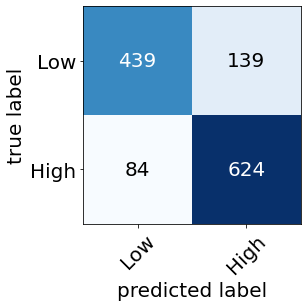

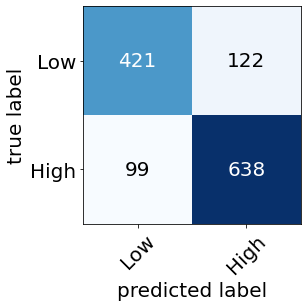

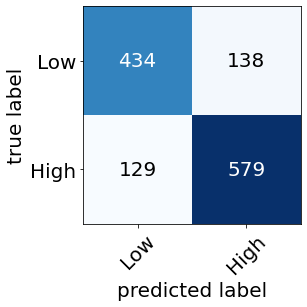

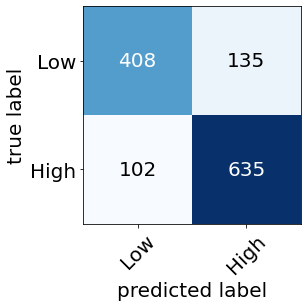

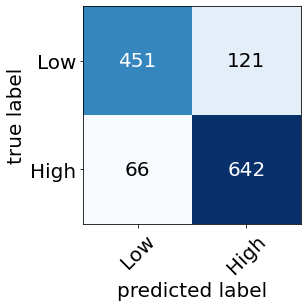

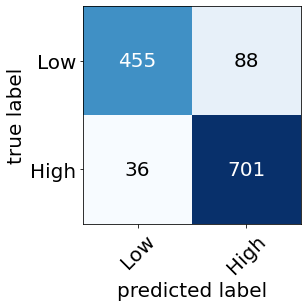

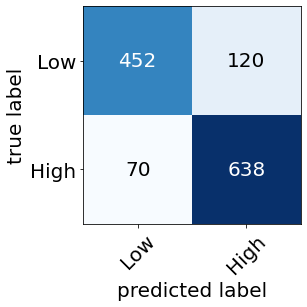

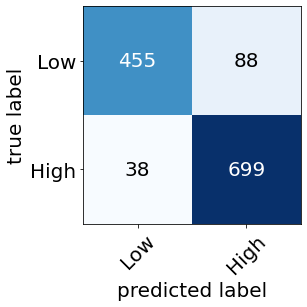

In [69]:
#Display Confusion Metrices 
class_names = ['Low','High'] # Class names
#=======================================================

## EEG_Valence
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 439,  139],
                                              [  84,  624]]) , 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence EEG.jpeg'

plt.savefig(fname1, bbox_inches='tight')
#=======================================================

##EEG Arousal
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 421,  122],
                                              [  99,  638]]), 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence arousal.jpeg'

plt.savefig(fname1, bbox_inches='tight')
## ========================================================

## EDA Valence

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 434,  138],
                                              [  129,  579]]), 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(3)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence EDA.jpeg'

plt.savefig(fname1, bbox_inches='tight')
#=========================================================
##EDA Arousal

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 408,  135],
                                              [  102,  635]]), 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(4)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' arousal EDA.jpeg'

plt.savefig(fname1, bbox_inches='tight')

#=========================================================

##Resp Valence

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 451,  121],
                                              [  66,  642]]), 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(5)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence resp belt.jpeg'

plt.savefig(fname1, bbox_inches='tight')

#========================================================
## Resp Arousal

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 455,  88],
                                              [  36,  701]]), 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(6)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' arousal resp belt.jpeg'

plt.savefig(fname1, bbox_inches='tight')

#=========================================================

#ReMECS Valence

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 452,  120],
                                              [  70,  638]]), 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(7)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence ReMECS.jpeg'

plt.savefig(fname1, bbox_inches='tight')

#==========================================================
#ReMECS Arousal

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=np.array([[ 455,  88],
                                              [  38,  699]]), 
                                  show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(8)
# plt.show()

fname1 = str(time_stamp)+ classifier+ 'arousal ReMECS.jpeg'

plt.savefig(fname1, bbox_inches='tight')



In [11]:
time_stamp = datetime.datetime.now()
fname_eeg = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_EEG'+'_' +classifier+'_results.csv'
np.savetxt(fname_eeg,eeg_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f','%f', '%f', '%f', '%f', '%d','%d','%d','%d'], comments='', 
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro, y_act_val, y_pred_val, y_act_aro, y_pred_aro')

fname_eda = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_EDA'+'_' +classifier+'_results.csv'
np.savetxt(fname_eda,eda_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro,y_act_val, y_pred_val, y_act_aro, y_pred_aro')

fname_resp = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_RESP_BELT'+'_' +classifier+'_results.csv'
np.savetxt(fname_resp,resp_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f','%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro,y_act_val, y_pred_val, y_act_aro, y_pred_aro')

fname_mer = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_MER'+'_' +classifier+'_results.csv'
np.savetxt(fname_mer,mer_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f','%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro,y_act_val, y_pred_val, y_act_aro, y_pred_aro')
    

EEG Valence accuracy:0.83046875
EEG Valence F1 Score:0.8518771331058022
Valence Confiusion matric:[[439 133]
 [ 84 624]]
 
EEG Valence Classification Report
              precision    recall  f1-score   support

         Low       0.84      0.77      0.80       572
        High       0.82      0.88      0.85       708

    accuracy                           0.83      1280
   macro avg       0.83      0.82      0.83      1280
weighted avg       0.83      0.83      0.83      1280

EEG Arousal accuracy:
0.82734375
 
EEG Arousal F1 Score
0.8523714094856379
 
EEG Arousal Confiusion matric
[[421 122]
 [ 99 638]]
 
EEG Arousal classification Report
              precision    recall  f1-score   support

         Low       0.81      0.78      0.79       543
        High       0.84      0.87      0.85       737

    accuracy                           0.83      1280
   macro avg       0.82      0.82      0.82      1280
weighted avg       0.83      0.83      0.83      1280



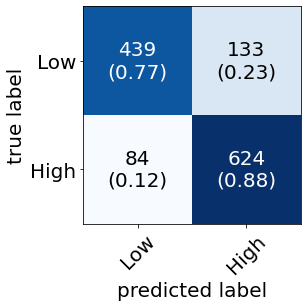

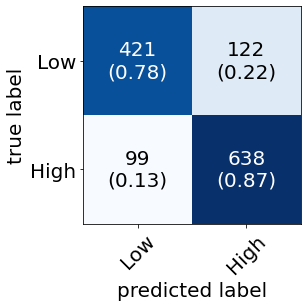

In [30]:
#===============================
# EEG results
#===============================

df = pd.read_csv(fname_eeg)
# print(df)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('EEG Valence accuracy:{}'.format(val_acc_score))
print('EEG Valence F1 Score:{}'.format(val_f1_scr))
print('Valence Confiusion matric:{}'.format(cm))

print(' ')

# print('Accuracy score', acc_score)

print('EEG Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence EEG.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('EEG Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('EEG Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('EEG Arousal Confiusion matric')
print(cm)

print(' ')

print('EEG Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal EEG.jpeg'

plt.savefig(fname2, bbox_inches='tight')

EDA Valence accuracy:
0.79140625
 
EDA Valence F1 Score
0.8126315789473685
 
EDA Valence Confiusion matric
[[434 138]
 [129 579]]
 
EDA Valence Classification Report
              precision    recall  f1-score   support

         Low       0.77      0.76      0.76       572
        High       0.81      0.82      0.81       708

    accuracy                           0.79      1280
   macro avg       0.79      0.79      0.79      1280
weighted avg       0.79      0.79      0.79      1280

EDA Arousal accuracy:
0.81484375
 
EDA Arousal F1 Score
0.8427339084273391
 
EDA Arousal Confiusion matric
[[408 135]
 [102 635]]
 
EDA Arousal classification Report
              precision    recall  f1-score   support

         Low       0.80      0.75      0.77       543
        High       0.82      0.86      0.84       737

    accuracy                           0.81      1280
   macro avg       0.81      0.81      0.81      1280
weighted avg       0.81      0.81      0.81      1280



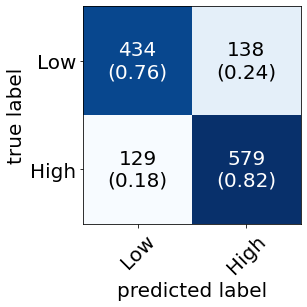

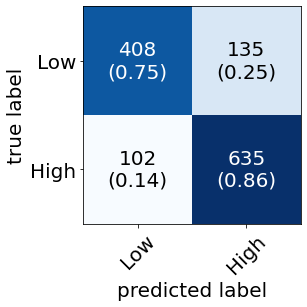

In [31]:
#===============================
# EDA results
#===============================

df = pd.read_csv(fname_eda)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('EDA Valence accuracy:')
print(val_acc_score)

print(' ')
print('EDA Valence F1 Score')
print(val_f1_scr)

print(' ')

print('EDA Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('EDA Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+classifier+'valence EDA.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('EDA Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('EDA Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('EDA Arousal Confiusion matric')
print(cm)

print(' ')

print('EDA Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal EDA.jpeg'

plt.savefig(fname2, bbox_inches='tight')

RESP BELT Valence accuracy:
0.85390625
 
RESP BELT Valence F1 Score
0.8728755948334467
 
RESP BELT Valence Confiusion matric
[[451 121]
 [ 66 642]]
 
RESP BELT Valence Classification Report
              precision    recall  f1-score   support

         Low       0.87      0.79      0.83       572
        High       0.84      0.91      0.87       708

    accuracy                           0.85      1280
   macro avg       0.86      0.85      0.85      1280
weighted avg       0.86      0.85      0.85      1280

RESP BELT Arousal accuracy:
0.903125
 
RESP BELT Arousal F1 Score
0.9187418086500656
 
RESP BELT Arousal Confiusion matric
[[455  88]
 [ 36 701]]
 
RESP BELT Arousal classification Report
              precision    recall  f1-score   support

         Low       0.93      0.84      0.88       543
        High       0.89      0.95      0.92       737

    accuracy                           0.90      1280
   macro avg       0.91      0.89      0.90      1280
weighted avg       0.90

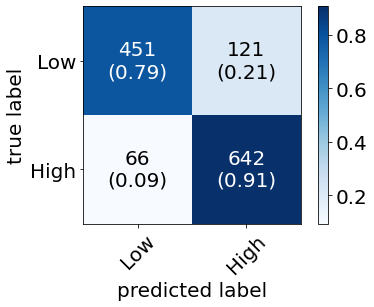

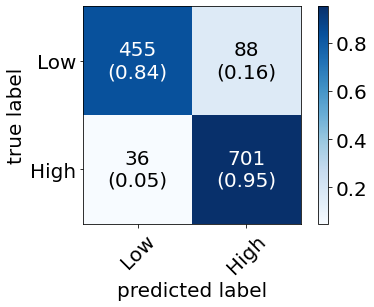

In [32]:
#===============================
# RESP BELT results
#===============================

df = pd.read_csv(fname_resp)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('RESP BELT Valence accuracy:')
print(val_acc_score)

print(' ')
print('RESP BELT Valence F1 Score')
print(val_f1_scr)

print(' ')

print('RESP BELT Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('RESP BELT Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+classifier+' valence RESP BELT.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('RESP BELT Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('RESP BELT Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('RESP BELT Arousal Confiusion matric')
print(cm)

print(' ')

print('RESP BELT Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal RESP BELT.jpeg'

plt.savefig(fname2, bbox_inches='tight')

MER Valence accuracy:
0.8515625
 
MER Valence F1 Score
0.8703956343792633
 
MER Valence Confiusion matric
[[452 120]
 [ 70 638]]
 
MER Valence Classification Report
              precision    recall  f1-score   support

         Low       0.87      0.79      0.83       572
        High       0.84      0.90      0.87       708

    accuracy                           0.85      1280
   macro avg       0.85      0.85      0.85      1280
weighted avg       0.85      0.85      0.85      1280

MER Arousal accuracy:
0.9015625
 
MER Arousal F1 Score
0.9173228346456692
 
MER Arousal Confiusion matric
[[455  88]
 [ 38 699]]
 
MER Arousal classification Report
              precision    recall  f1-score   support

         Low       0.92      0.84      0.88       543
        High       0.89      0.95      0.92       737

    accuracy                           0.90      1280
   macro avg       0.91      0.89      0.90      1280
weighted avg       0.90      0.90      0.90      1280



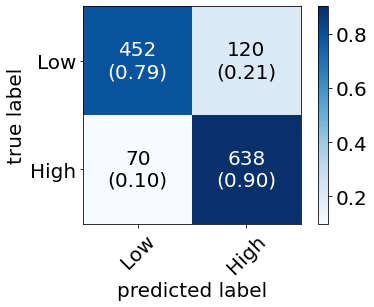

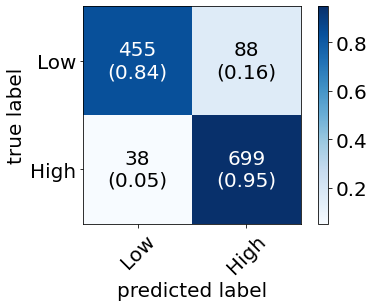

In [33]:
#==========================================
# Multi Modal Emotion Recognition results
#==========================================

df = pd.read_csv(fname_mer)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('MER Valence accuracy:')
print(val_acc_score)

print(' ')
print('MER Valence F1 Score')
print(val_f1_scr)

print(' ')

print('MER Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('MER Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+'LR-SGD valence MER.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('MER Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('MER Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('MER Arousal Confiusion matric')
print(cm)

print(' ')

print('MER Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+'LR-SGD arousal MER.jpeg'

plt.savefig(fname2, bbox_inches='tight')